In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

#sklearn
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, RobustScaler, StandardScaler

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, auc
from sklearn.metrics import roc_auc_score, precision_score, recall_score, make_scorer
from sklearn.metrics import plot_confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV
from sklearn.inspection import permutation_importance

from sklearn.neighbors import KNeighborsClassifier

#json
import json

<h3>Functions</h3>

In [2]:
def plot_grid_search_results(grid_results, grid_best_params, grid_best_score):
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize = (12,18)) #figsize = (13,30)
    
    ax1.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_f1'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_f1'],
                 ecolor = 'orange')
    ax1.set_xlabel('n_neigbors')
    ax1.set_ylabel('f1')
    ax1.set_title('Classification F1')
    
    ax2.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_recall'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_recall'],
                 ecolor = 'orange')
    ax2.set_xlabel('n_neigbors') 
    ax2.set_ylabel('recall')
    ax2.set_title('Classification Recall')
    
    ax3.errorbar(x = grid_results['param_n_neighbors'].data, 
                 y = grid_results['mean_test_roc_auc'],
                 color = '#B8002E',
                 yerr = grid_results['std_test_roc_auc'],
                 ecolor = 'orange')
    ax3.plot([grid_best_params['n_neighbors']], [grid_best_score], 
              marker='.', 
              markeredgewidth=3,
              c='r')
    ax3.annotate('best k', xy = (grid_best_params['n_neighbors'], grid_best_score),
                 xytext = (grid_best_params['n_neighbors'] + 1, grid_best_score + 0.02),
                 arrowprops=dict(facecolor='black', shrink=0.01))
    ax3.set_xlabel('n_neigbors') 
    ax3.set_ylabel('roc auc')
    ax3.set_title('Classification Roc Auc')

    fig.tight_layout()
    plt.show()

In [3]:
def results_permutation_importance(res, attr):
    
    # get importance
    importance = res.importances_mean
    
    # summarize feature importance
    feature_importances = []
    for col, imp in zip(attr, importance):
        feature_importances.append((col, imp))
  
    sorted_feature_importances = sorted(feature_importances, key=lambda tup:(-tup[1], tup[0]))
    
    return sorted_feature_importances

In [4]:
def plot_permutation_importance(res, attr, tit):
    
    fig, ax = plt.subplots(figsize = (12,8)) 
    
    feature_names = np.r_[attr]
    
    importance = res.importances_mean
    sorted_idx = res.importances_mean.argsort()
    
    y_ticks = np.arange(0, len(feature_names))
    ax.barh(y_ticks, importance[sorted_idx], height=0.7, color = "#CC6600")
    ax.set_yticklabels(feature_names[sorted_idx])
    ax.set_yticks(y_ticks)
    ax.set_title(tit)
    
    fig.tight_layout()
    plt.show()

In [5]:
def draw_confusion_matrix(Clf, X, y):
    
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(Clf, X, y,
                                 cmap='OrRd',
                                 normalize=normalize)
        disp.ax_.set_title(title)
    
    plt.show()

In [6]:
def draw_roc_curve(Y_test, Y_pred, diz, k):
    
    fig, ax = plt.subplots() #figsize = (13,30)
    
    fpr, tpr, _ = roc_curve(Y_test, Y_pred)
    roc_auc = roc_auc_score(Y_test, Y_pred, average = None)
    
    diz[k] = {"fpr": fpr.tolist(), "tpr": tpr.tolist(), "roc": roc_auc}
    
    ax.plot(fpr, tpr, color = "#994D00", label='ROC curve (area = %0.2f)' % (roc_auc))
    ax.plot([0, 1], [0, 1], 'r--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate') 
    ax.set_title('Roc curve of the model')
    ax.tick_params(axis='both')
    ax.legend(loc="lower right", fontsize=14, frameon=False)
    
    fig.tight_layout()
    plt.show()

In [7]:
df = pd.read_csv("Numerical_NON_NORMALIZED_Train_HR_Employee_Attrition.csv")

In [8]:
df

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
0,52,0,0,1,0,9,4,2,0,3,...,17,3,0,2,2,8,7,156.61,0.39,2
1,36,0,0,1,0,1,1,2,0,3,...,14,3,1,3,3,1,8,157.94,0.41,2
2,25,0,0,0,1,16,3,3,0,3,...,25,3,1,4,3,1,5,448.06,0.70,3
3,33,0,0,1,0,5,4,2,0,3,...,14,2,0,1,3,3,7,271.91,0.84,2
4,31,0,0,1,0,9,2,3,1,3,...,12,3,0,2,3,10,2,106.37,0.21,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
878,38,1,0,1,0,12,3,3,1,4,...,15,4,0,2,3,10,0,282.47,0.79,3
879,37,0,0,1,0,16,2,4,1,4,...,13,2,2,3,2,17,0,76.29,0.71,3
880,33,1,1,0,0,6,4,2,1,1,...,18,2,0,2,2,11,7,272.88,0.75,2
881,33,0,0,1,0,4,1,3,0,2,...,12,1,0,2,4,3,2,208.67,0.86,2


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 36 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Age                                     883 non-null    int64  
 1   Attrition                               883 non-null    int64  
 2   BusinessTravel_Non-Travel               883 non-null    int64  
 3   BusinessTravel_Travel_Rarely            883 non-null    int64  
 4   BusinessTravel_Travel_Frequently        883 non-null    int64  
 5   DistanceFromHome                        883 non-null    int64  
 6   Education                               883 non-null    int64  
 7   EnvironmentSatisfaction                 883 non-null    int64  
 8   Gender                                  883 non-null    int64  
 9   JobInvolvement                          883 non-null    int64  
 10  JobLevel                                883 non-null    int64 

In [10]:
df.describe()

,Age,Attrition,BusinessTravel_Non-Travel,BusinessTravel_Travel_Rarely,BusinessTravel_Travel_Frequently,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,JobInvolvement,...,PercentSalaryHike,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,MonthlyHours,TaxRate,OverallSatisfaction
count,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,...,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000,883.000000
mean,36.554926,0.173273,0.101925,0.733862,0.164213,9.201586,2.886750,2.684032,0.388448,2.750849,...,15.207248,2.716874,0.793884,2.665912,2.767837,6.326161,3.919592,234.245832,0.463918,2.322763
std,8.266129,0.378698,0.302721,0.442188,0.370679,8.241818,1.008285,1.092567,0.487674,0.729354,...,3.589332,1.078137,0.865362,1.187828,0.721713,4.523567,3.435392,130.196652,0.319880,0.535595
min,18.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1.000000,...,11.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,26.040000,0.000000,1.000000
25%,30.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,0.000000,2.000000,...,12.000000,2.000000,0.000000,2.000000,2.000000,3.000000,2.000000,130.630000,0.130000,2.000000
50%,35.000000,0.000000,0.000000,1.000000,0.000000,7.000000,3.000000,3.000000,0.000000,3.000000,...,14.000000,3.000000,1.000000,2.000000,3.000000,5.000000,3.000000,212.280000,0.530000,2.000000
75%,42.000000,0.000000,0.000000,1.000000,0.000000,14.000000,4.000000,4.000000,1.000000,3.000000,...,18.000000,4.000000,1.000000,3.000000,3.000000,9.000000,7.000000,309.905000,0.760000,3.000000
max,60.000000,1.000000,1.000000,1.000000,1.000000,29.000000,5.000000,4.000000,1.000000,4.000000,...,25.000000,4.000000,3.000000,6.000000,4.000000,20.000000,16.000000,590.980000,0.950000,4.000000


<h3>Feature selection</h3>

In [11]:
features_sel = [col for col in df.columns if col != 'Attrition']

X_features_sel = df[features_sel].values
y_features_sel = df['Attrition']

OverTime                                           0.028688
JobSatisfaction                                    0.010772
JobRole_Sales_Representative                       0.008774
EnvironmentSatisfaction                            0.008512
JobRole_Laboratory_Technician                      0.008238
JobRole_Manufacturing_Director                     0.007042
WorkLifeBalance                                    0.005505
StockOptionLevel                                   0.005427
JobRole_Research_Scientist                         0.005383
JobInvolvement                                     0.004989
TrainingTimesLastYear                              0.004397
Age                                                0.004272
NumCompaniesWorked                                 0.004264
OverallSatisfaction                                0.004192
RelationshipSatisfaction                           0.003989
YearsInCurrentRole                                 0.002600
JobRole_Healthcare_Representative       

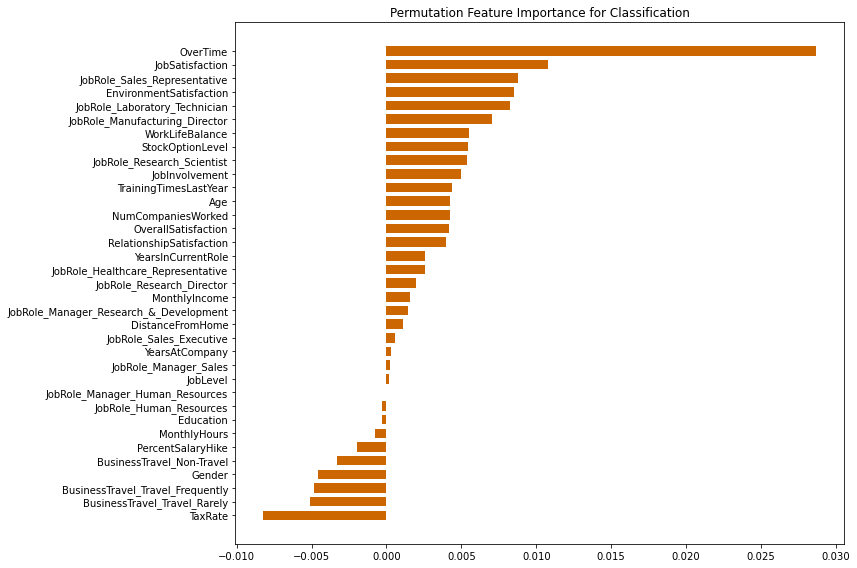

In [12]:
scaler_prova = MinMaxScaler()
X_features_sel_normalized = scaler_prova.fit_transform(X_features_sel)

model = KNeighborsClassifier()

model.fit(X_features_sel_normalized, y_features_sel)

results_features_sel = permutation_importance(model, X_features_sel_normalized, y_features_sel, scoring='roc_auc', n_repeats = 10)

sorted_feat_imp = results_permutation_importance(results_features_sel, features_sel)

#print results
for t in sorted_feat_imp:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
#plot results
t = 'Permutation Feature Importance for Classification'
plot_permutation_importance(results_features_sel, features_sel, t)

In [13]:
df = df.drop(['YearsInCurrentRole','JobRole_Manager_Sales',
              'JobRole_Manager_Human_Resources', 'JobRole_Sales_Executive',
              'JobRole_Human_Resources','YearsAtCompany', 'MonthlyIncome','MonthlyHours',
              'Education','Gender','BusinessTravel_Non-Travel',
              'PercentSalaryHike','BusinessTravel_Travel_Frequently',
              'BusinessTravel_Travel_Rarely','TaxRate', 'JobRole_Healthcare_Representative'], axis = 1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 883 entries, 0 to 882
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype
---  ------                                  --------------  -----
 0   Age                                     883 non-null    int64
 1   Attrition                               883 non-null    int64
 2   DistanceFromHome                        883 non-null    int64
 3   EnvironmentSatisfaction                 883 non-null    int64
 4   JobInvolvement                          883 non-null    int64
 5   JobLevel                                883 non-null    int64
 6   JobRole_Laboratory_Technician           883 non-null    int64
 7   JobRole_Manager_Research_&_Development  883 non-null    int64
 8   JobRole_Manufacturing_Director          883 non-null    int64
 9   JobRole_Research_Director               883 non-null    int64
 10  JobRole_Research_Scientist              883 non-null    int64
 11  JobRole_Sales_Repre

In [15]:
df.head()

,Age,Attrition,DistanceFromHome,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobRole_Laboratory_Technician,JobRole_Manager_Research_&_Development,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Representative,JobSatisfaction,NumCompaniesWorked,OverTime,RelationshipSatisfaction,StockOptionLevel,TrainingTimesLastYear,WorkLifeBalance,OverallSatisfaction
0,52,0,9,2,3,3,0,0,0,1,0,0,3,9,0,3,0,2,2,2
1,36,0,1,2,3,5,0,1,0,0,0,0,3,1,1,3,1,3,3,2
2,25,0,16,3,3,2,0,0,0,0,0,0,4,1,1,3,1,4,3,3
3,33,0,5,2,3,1,0,0,0,0,1,0,2,2,0,2,0,1,3,2
4,31,0,9,3,3,1,1,0,0,0,0,0,4,1,0,3,0,2,3,3


<h3>Divide into features and target</h3>

In [16]:
attributes = [col for col in df.columns if col != 'Attrition']

X = df[attributes].values
y = df['Attrition']

<h3>Stratified Holdout combined with Stratified K-fold Cross Validation</h3>

In [17]:
scaler_dict = dict()

<h4>MinMaxScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6450252928164775
Best parameters: {'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')

Best k ('n_neighbors'): 4

Plots of the metrics used by the grid search


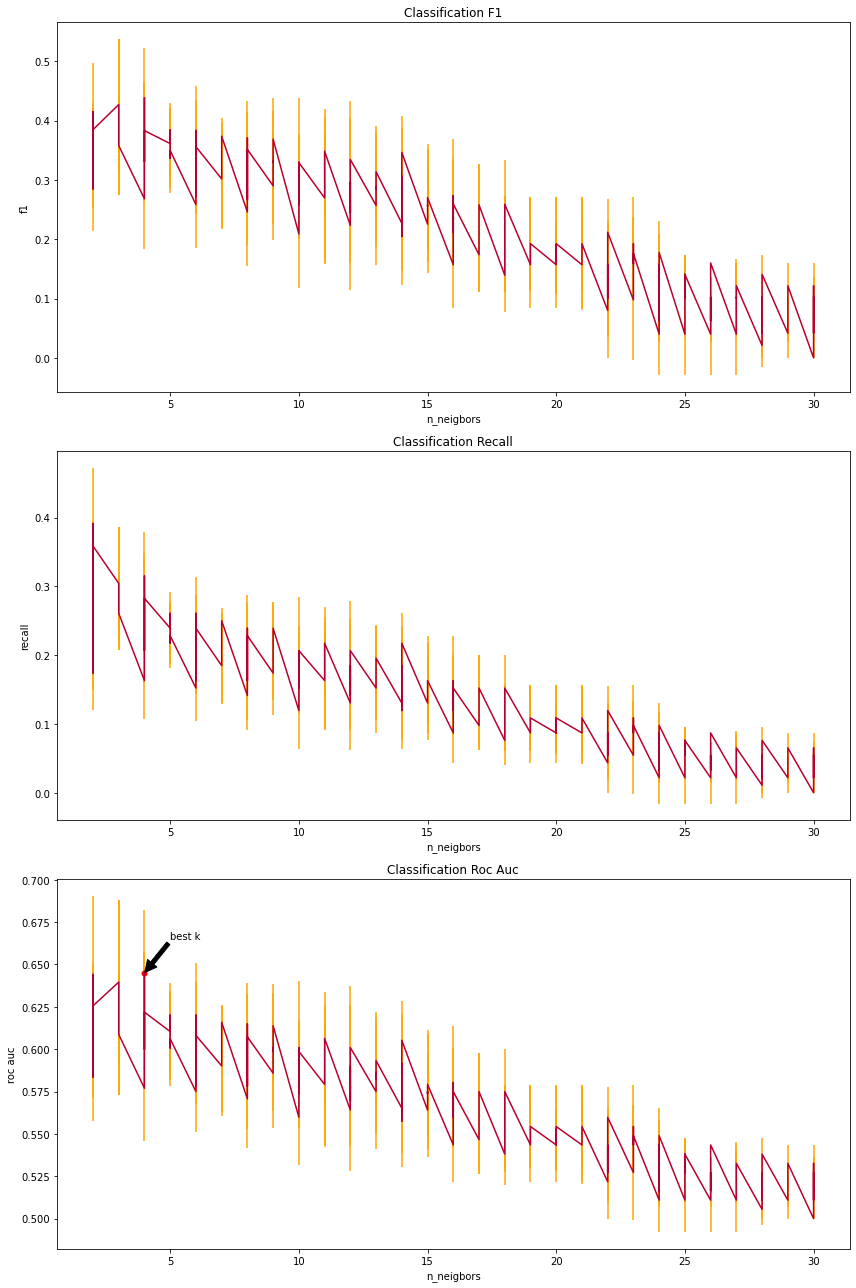



Permutation importances of the training set

OverTime                                           0.007606
JobRole_Laboratory_Technician                      0.003403
RelationshipSatisfaction                           0.001333
JobRole_Sales_Representative                       0.000930
JobSatisfaction                                    0.000791
EnvironmentSatisfaction                            0.000706
StockOptionLevel                                   0.000634
JobRole_Manufacturing_Director                     0.000376
JobRole_Research_Scientist                         0.000353
DistanceFromHome                                   0.000211
NumCompaniesWorked                                 0.000192
WorkLifeBalance                                    0.000057
JobInvolvement                                     0.000037
Age                                                0.000002
JobRole_Research_Director                          0.000002
JobLevel                                           0.

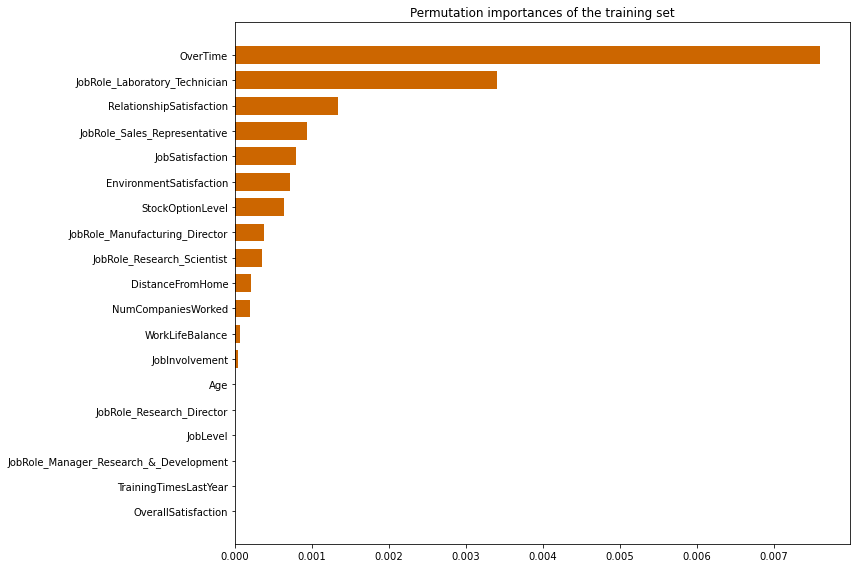



Predictions

Permutation importances of the test set

OverTime                                           0.039034
JobSatisfaction                                    0.038161
JobRole_Laboratory_Technician                      0.021868
EnvironmentSatisfaction                            0.020419
JobRole_Research_Scientist                         0.017938
StockOptionLevel                                   0.012888
WorkLifeBalance                                    0.012483
Age                                                0.009170
JobRole_Sales_Representative                       0.004918
JobRole_Research_Director                          0.001569
JobRole_Manager_Research_&_Development             0.000182
RelationshipSatisfaction                           -0.000862
JobLevel                                           -0.000923
JobInvolvement                                     -0.001888
TrainingTimesLastYear                              -0.003858
JobRole_Manufacturing_Director          

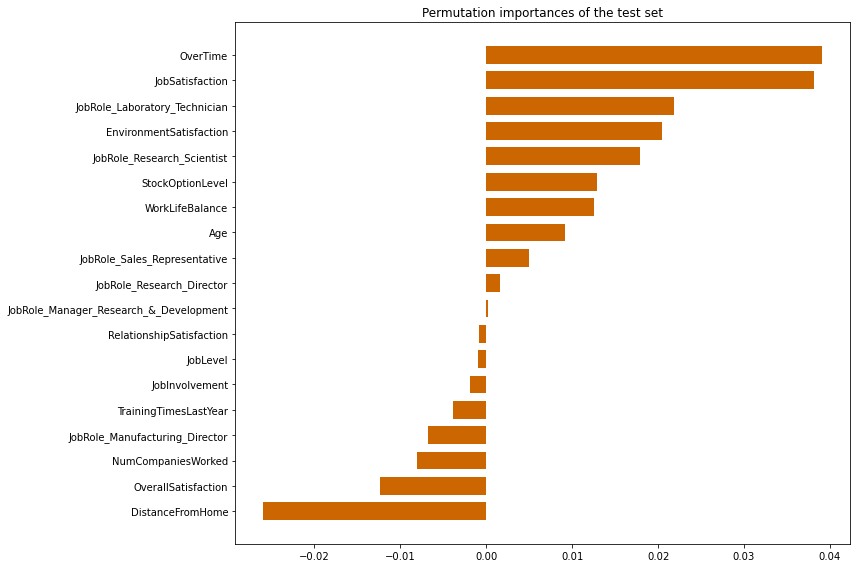



Confusion matrix


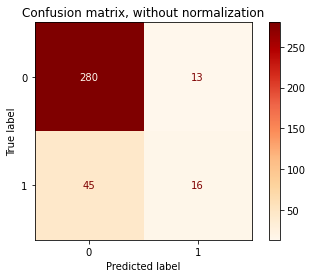

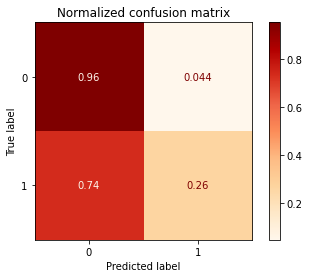


Classification report
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       293
           1       0.55      0.26      0.36        61

    accuracy                           0.84       354
   macro avg       0.71      0.61      0.63       354
weighted avg       0.81      0.84      0.81       354


Metrics

Accuracy 0.8361581920903954
F1-score [0.90614887 0.35555556]
Precision [0.86153846 0.55172414]
Recall [0.9556314  0.26229508]
Roc_auc 0.6089632406423097


Roc curve



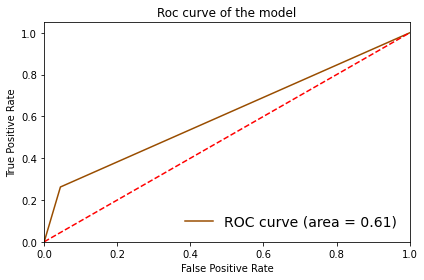


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6359449835397177
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


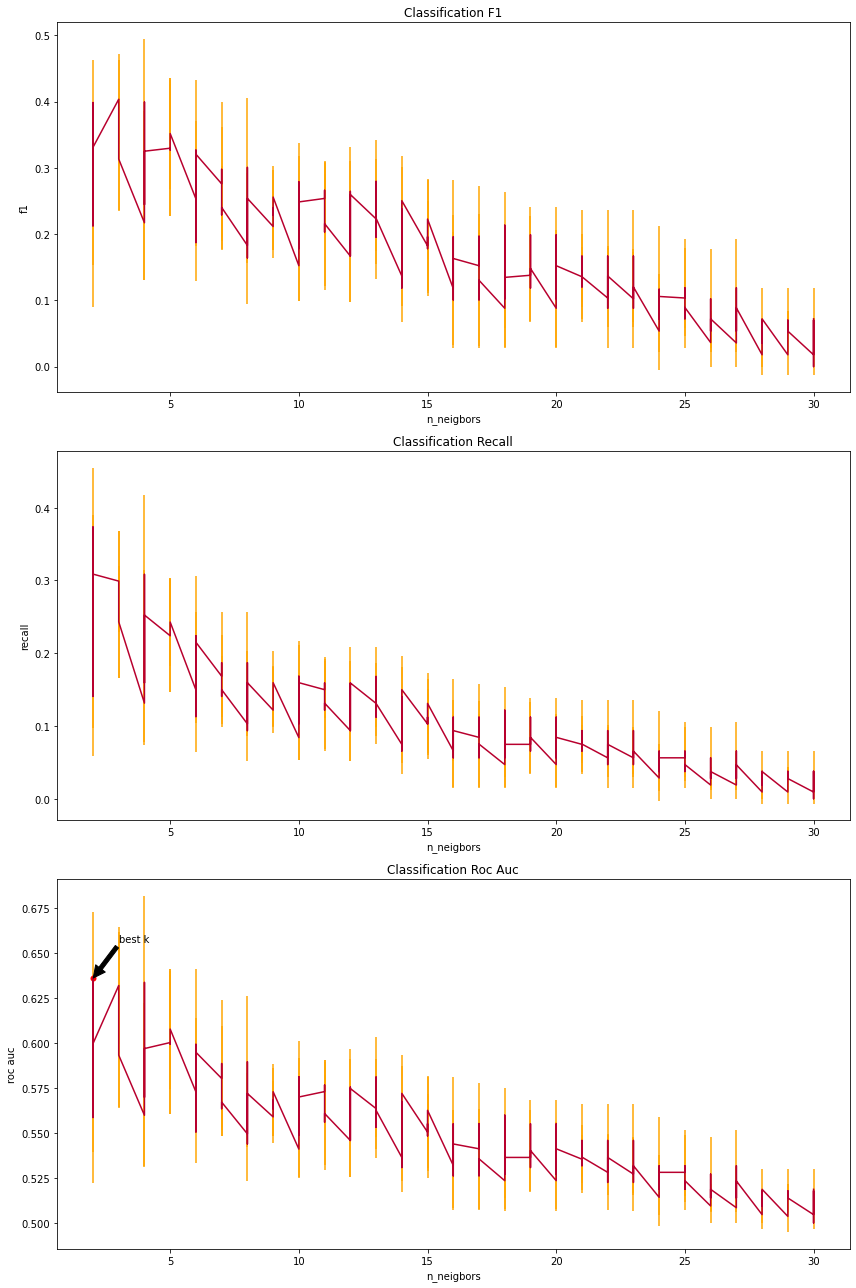



Permutation importances of the training set

OverTime                                           0.002411
DistanceFromHome                                   0.002058
JobSatisfaction                                    0.001557
JobRole_Laboratory_Technician                      0.000119
RelationshipSatisfaction                           0.000086
StockOptionLevel                                   0.000048
JobRole_Sales_Representative                       0.000005
NumCompaniesWorked                                 0.000002
EnvironmentSatisfaction                            0.000000
OverallSatisfaction                                0.000000
Age                                                0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.

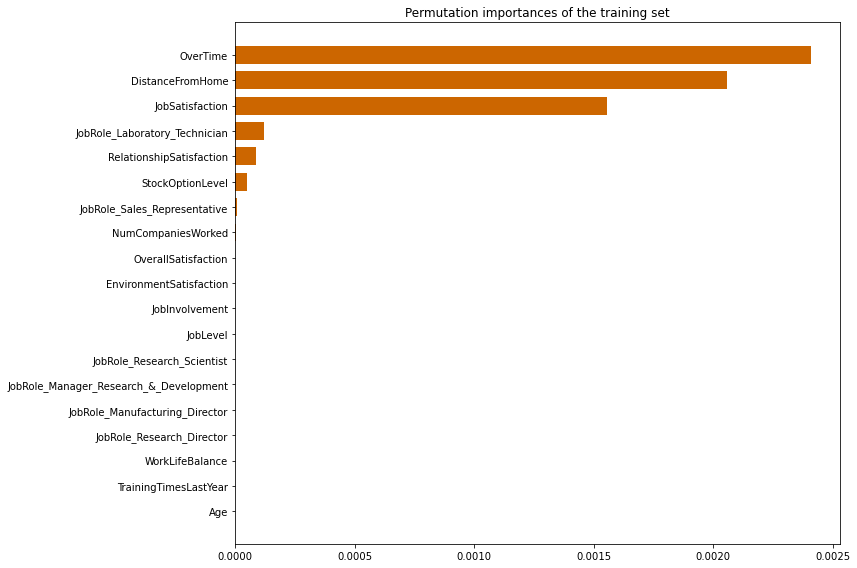



Predictions

Permutation importances of the test set

OverTime                                           0.080246
StockOptionLevel                                   0.036336
JobSatisfaction                                    0.032797
JobRole_Laboratory_Technician                      0.021228
JobInvolvement                                     0.020776
Age                                                0.020459
NumCompaniesWorked                                 0.008160
JobLevel                                           0.006239
WorkLifeBalance                                    0.005082
JobRole_Research_Director                          0.003097
JobRole_Manufacturing_Director                     0.002402
RelationshipSatisfaction                           0.001350
JobRole_Manager_Research_&_Development             0.000194
JobRole_Research_Scientist                         -0.000725
JobRole_Sales_Representative                       -0.002095
EnvironmentSatisfaction                   

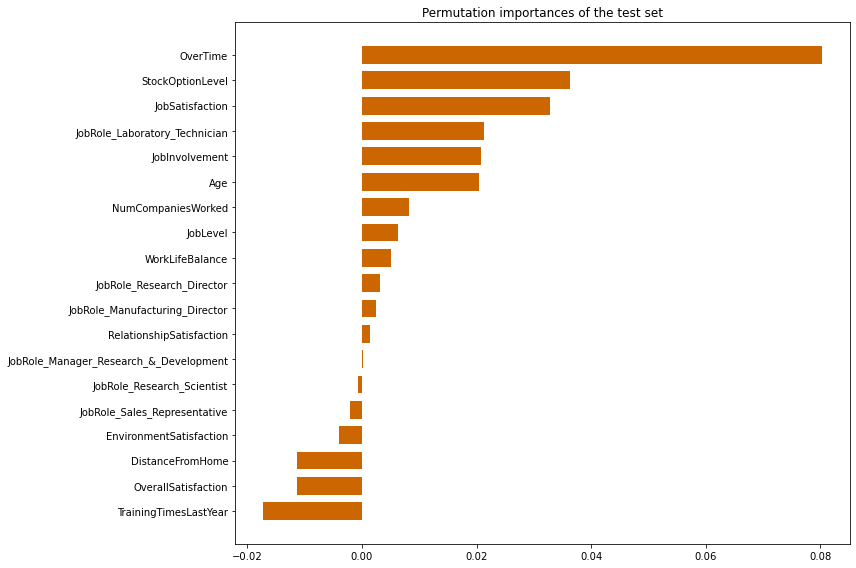



Confusion matrix


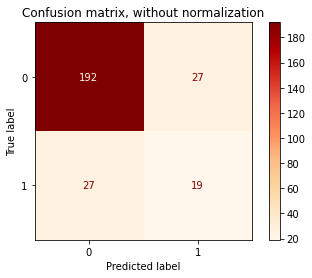

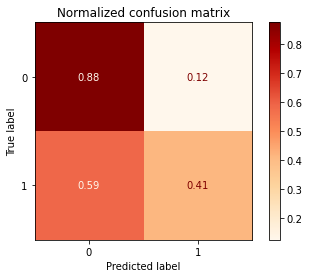


Classification report
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       219
           1       0.41      0.41      0.41        46

    accuracy                           0.80       265
   macro avg       0.64      0.64      0.64       265
weighted avg       0.80      0.80      0.80       265


Metrics

Accuracy 0.7962264150943397
F1-score [0.87671233 0.41304348]
Precision [0.87671233 0.41304348]
Recall [0.87671233 0.41304348]
Roc_auc 0.6448779035139963


Roc curve



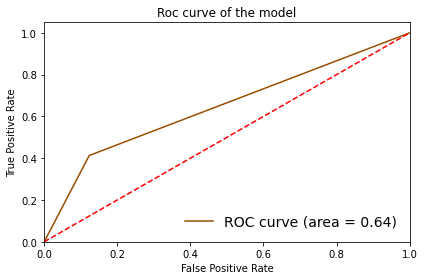


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6759942554131685
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


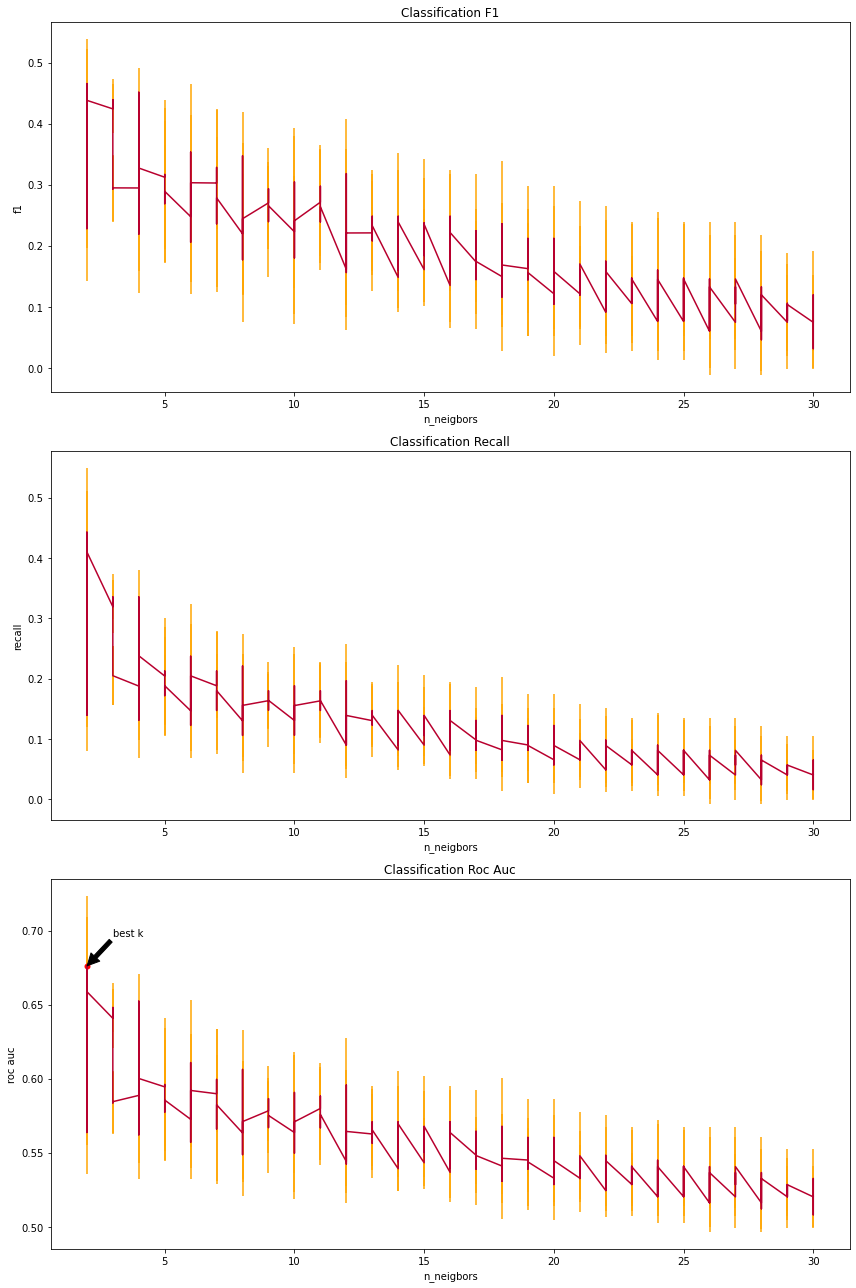



Permutation importances of the training set

OverTime                                           0.006483
RelationshipSatisfaction                           0.001851
JobSatisfaction                                    0.001834
DistanceFromHome                                   0.001349
StockOptionLevel                                   0.000467
JobRole_Laboratory_Technician                      0.000131
JobRole_Sales_Representative                       0.000074
EnvironmentSatisfaction                            0.000051
NumCompaniesWorked                                 0.000013
Age                                                0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.000000
JobRole_Research_Scientist                         0.

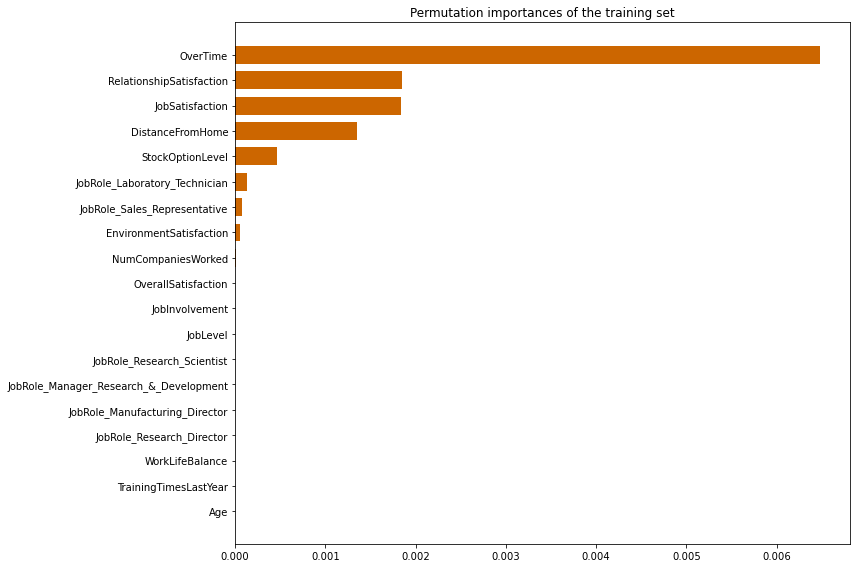



Predictions

Permutation importances of the test set

OverTime                                           0.066339
JobRole_Laboratory_Technician                      0.050166
StockOptionLevel                                   0.044167
JobSatisfaction                                    0.037506
JobInvolvement                                     0.022967
JobRole_Research_Scientist                         0.019719
NumCompaniesWorked                                 0.017565
WorkLifeBalance                                    0.016505
Age                                                0.007656
JobRole_Sales_Representative                       0.007236
RelationshipSatisfaction                           0.007004
JobRole_Research_Director                          0.004839
JobRole_Manufacturing_Director                     0.004010
EnvironmentSatisfaction                            0.002530
OverallSatisfaction                                0.001425
JobLevel                                    

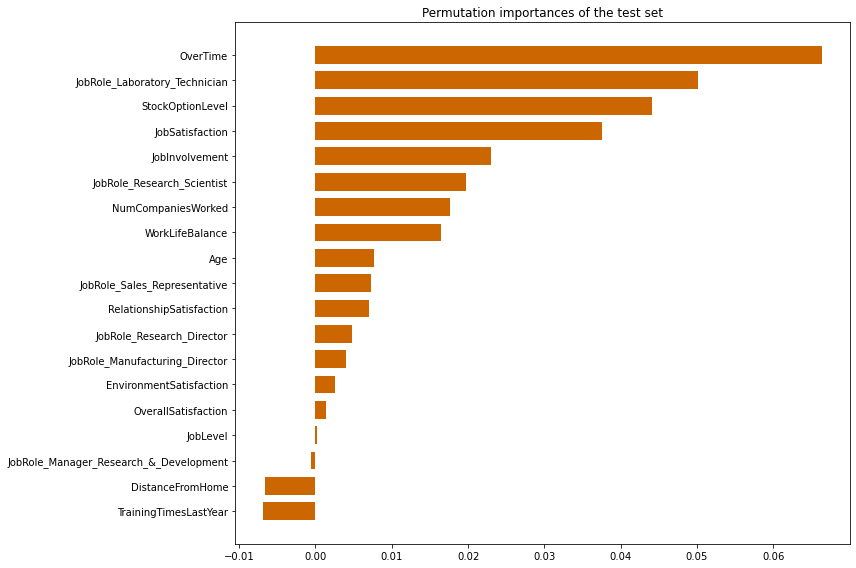



Confusion matrix


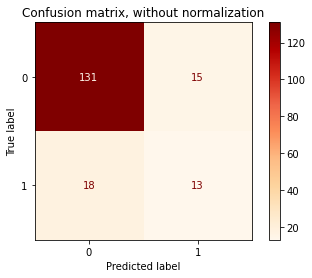

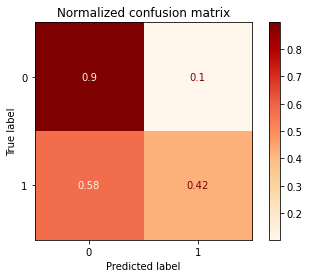


Classification report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       146
           1       0.46      0.42      0.44        31

    accuracy                           0.81       177
   macro avg       0.67      0.66      0.66       177
weighted avg       0.81      0.81      0.81       177


Metrics

Accuracy 0.8135593220338984
F1-score [0.88813559 0.44067797]
Precision [0.87919463 0.46428571]
Recall [0.89726027 0.41935484]
Roc_auc 0.6583075563411402


Roc curve



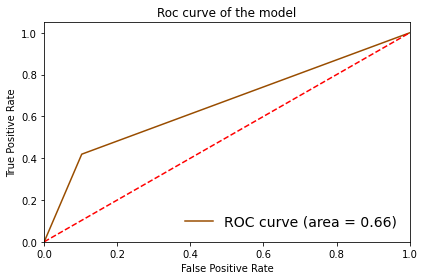


-------------------------------------------------------------------------------------------------------------



In [18]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
min_max_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MinMaxScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, min_max_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = min_max_dict

<h4>MaxAbsScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.645029825579287
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


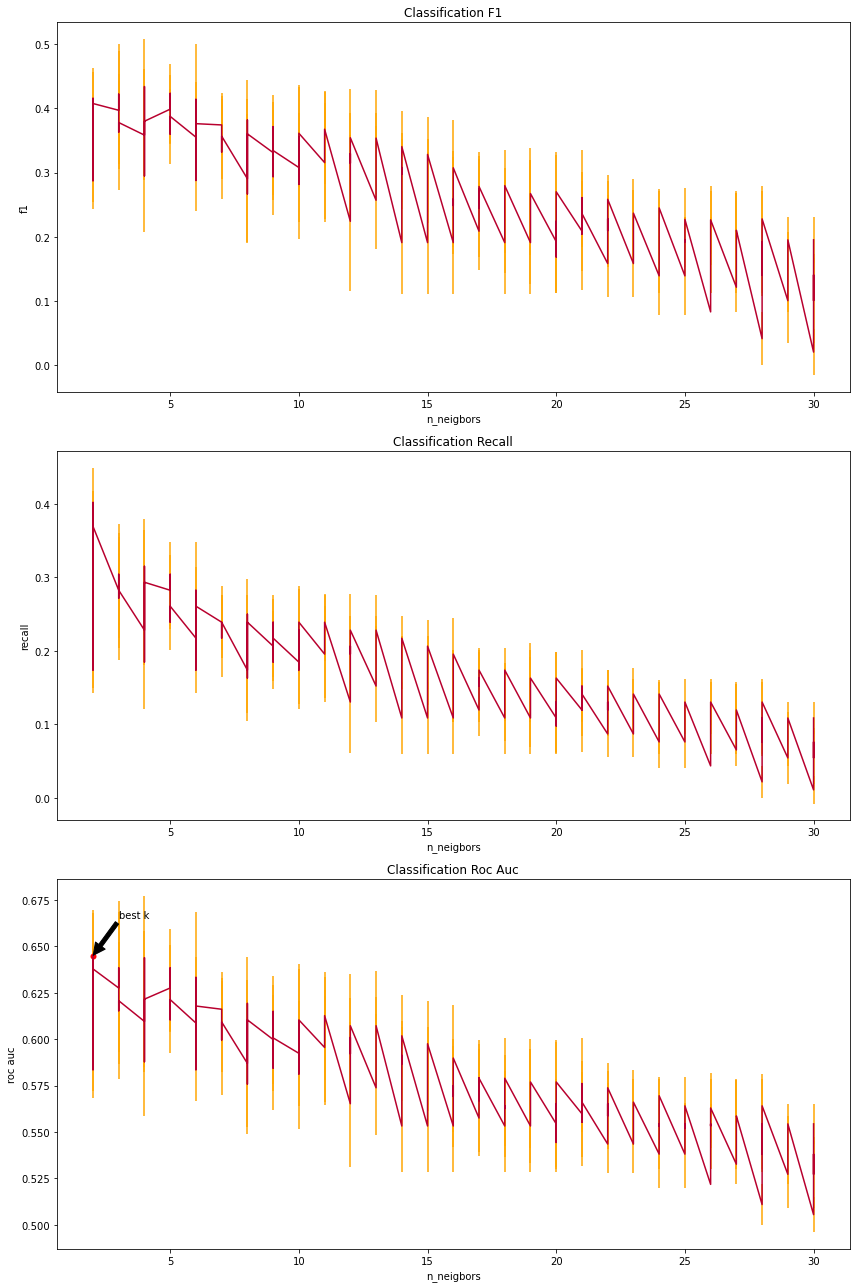



Permutation importances of the training set

JobRole_Laboratory_Technician                      0.010396
OverTime                                           0.006856
JobRole_Sales_Representative                       0.005034
JobSatisfaction                                    0.001782
StockOptionLevel                                   0.000700
JobRole_Research_Scientist                         0.000104
RelationshipSatisfaction                           0.000037
Age                                                0.000000
DistanceFromHome                                   0.000000
EnvironmentSatisfaction                            0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.000000
NumCompaniesWorked                                 0.

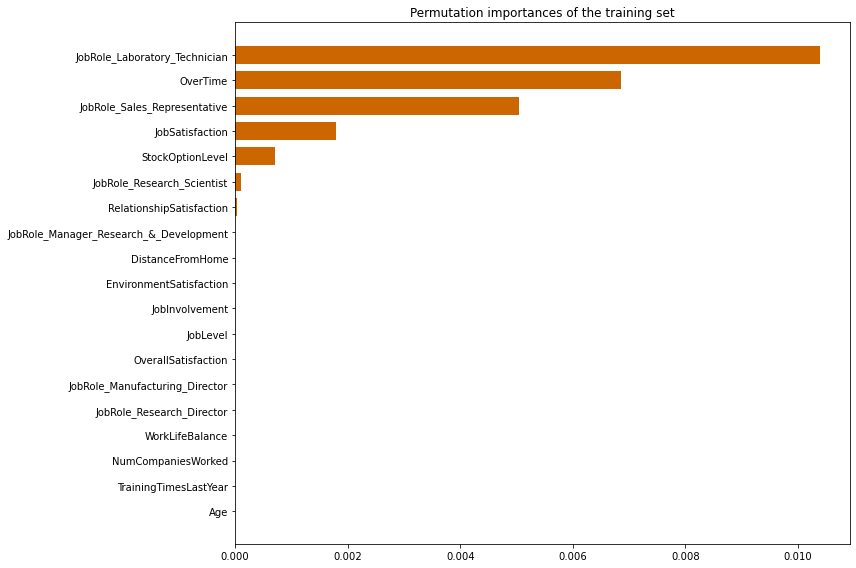



Predictions

Permutation importances of the test set

OverTime                                           0.039104
JobRole_Laboratory_Technician                      0.015168
WorkLifeBalance                                    0.011221
JobSatisfaction                                    0.009274
Age                                                0.008739
JobRole_Sales_Representative                       0.007895
JobRole_Research_Scientist                         0.005637
JobRole_Manufacturing_Director                     0.002968
JobRole_Research_Director                          0.001505
JobRole_Manager_Research_&_Development             -0.000638
JobLevel                                           -0.002291
JobInvolvement                                     -0.006096
NumCompaniesWorked                                 -0.012824
OverallSatisfaction                                -0.013646
StockOptionLevel                                   -0.014343
EnvironmentSatisfaction               

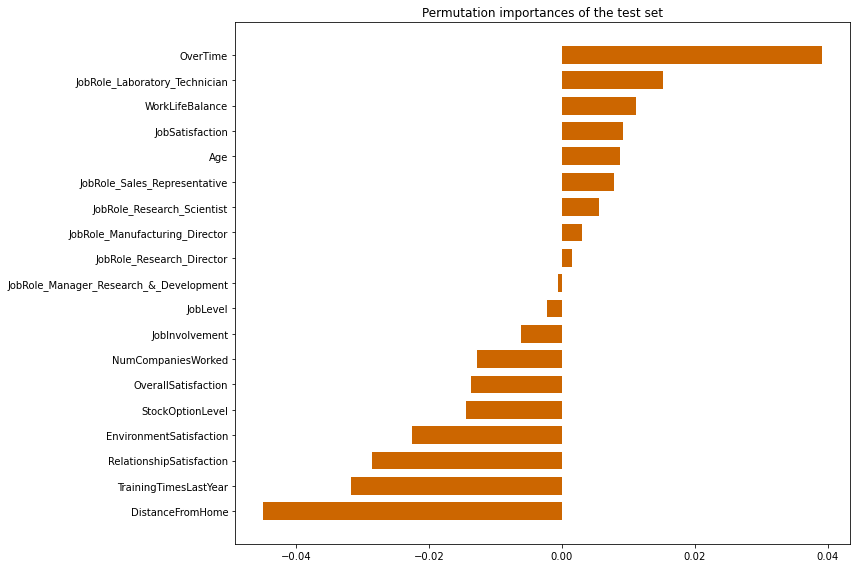



Confusion matrix


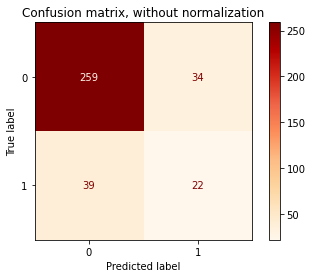

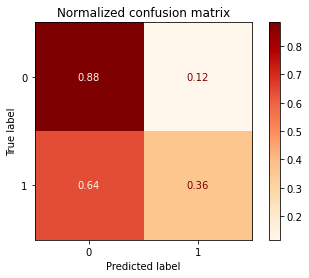


Classification report
              precision    recall  f1-score   support

           0       0.87      0.88      0.88       293
           1       0.39      0.36      0.38        61

    accuracy                           0.79       354
   macro avg       0.63      0.62      0.63       354
weighted avg       0.79      0.79      0.79       354


Metrics

Accuracy 0.7937853107344632
F1-score [0.87648054 0.37606838]
Precision [0.86912752 0.39285714]
Recall [0.88395904 0.36065574]
Roc_auc 0.6223073910367595


Roc curve



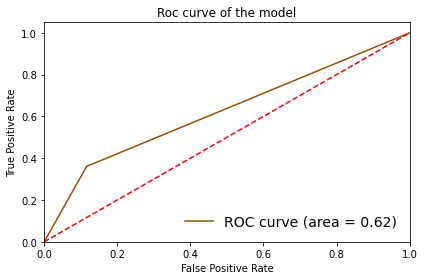


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6445039315748592
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


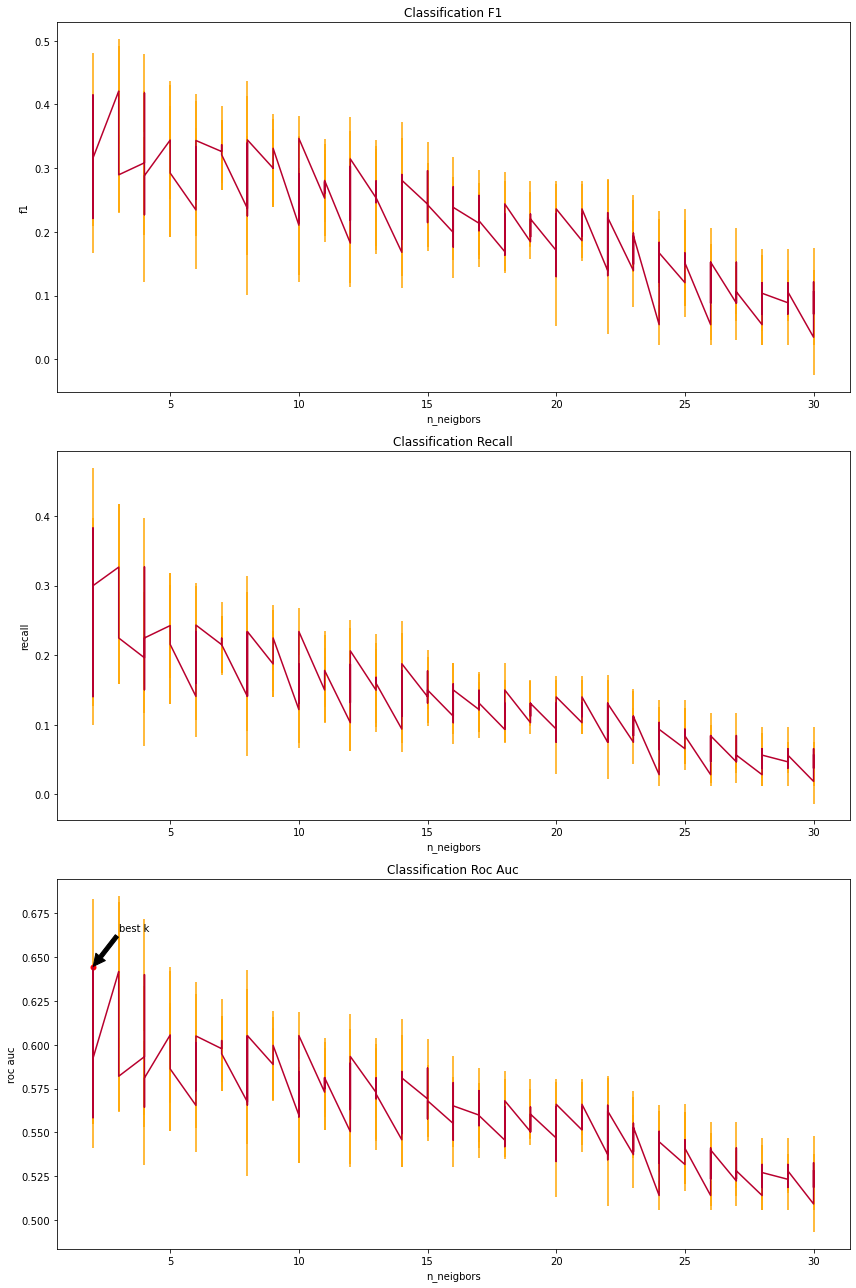



Permutation importances of the training set

JobRole_Laboratory_Technician                      0.008254
OverTime                                           0.005787
JobRole_Sales_Representative                       0.004796
JobSatisfaction                                    0.002507
JobRole_Research_Scientist                         0.001650
DistanceFromHome                                   0.001545
StockOptionLevel                                   0.000157
NumCompaniesWorked                                 0.000106
RelationshipSatisfaction                           0.000022
EnvironmentSatisfaction                            0.000000
Age                                                0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.

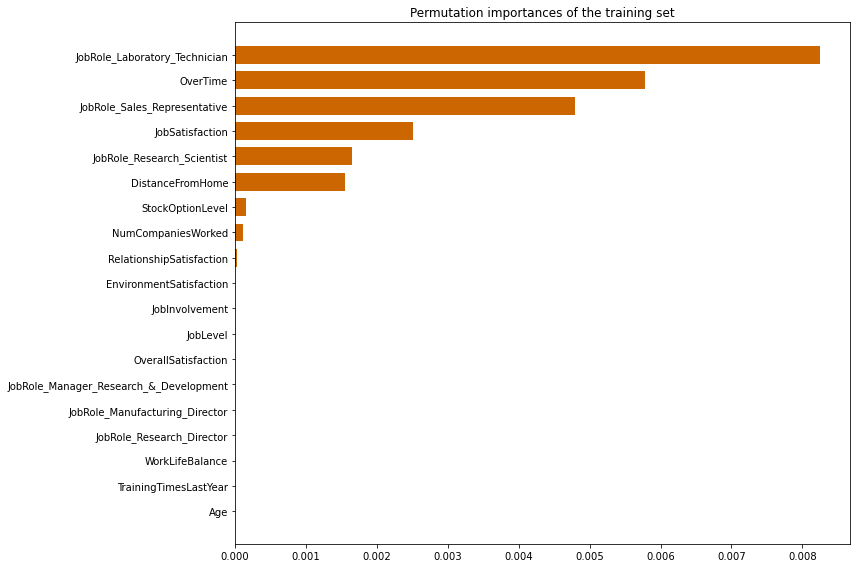



Predictions

Permutation importances of the test set

OverTime                                           0.038361
StockOptionLevel                                   0.030211
JobInvolvement                                     0.016875
JobRole_Sales_Representative                       0.011634
JobSatisfaction                                    0.008636
JobRole_Laboratory_Technician                      0.008378
JobRole_Manufacturing_Director                     0.002745
JobRole_Research_Director                          0.002303
JobRole_Manager_Research_&_Development             -0.000109
Age                                                -0.000844
JobRole_Research_Scientist                         -0.001266
NumCompaniesWorked                                 -0.001975
OverallSatisfaction                                -0.002060
EnvironmentSatisfaction                            -0.006626
RelationshipSatisfaction                           -0.011783
DistanceFromHome                     

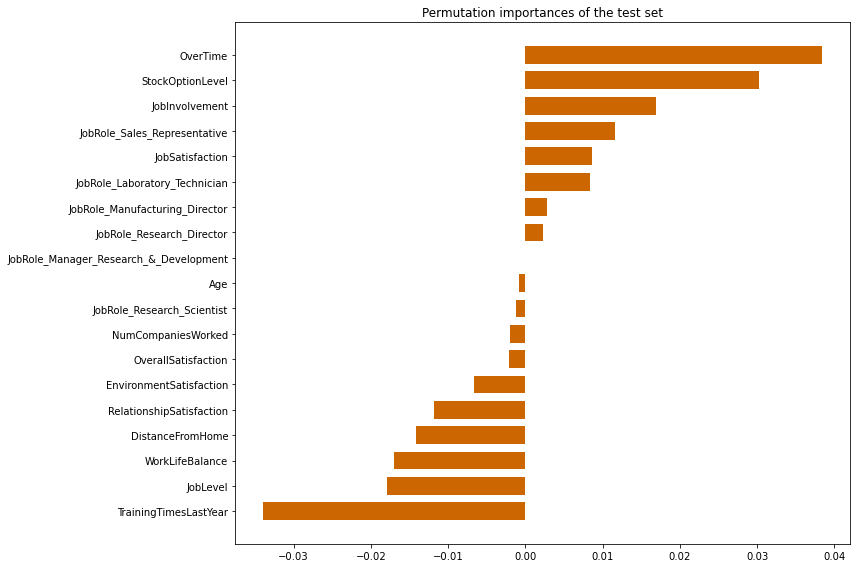



Confusion matrix


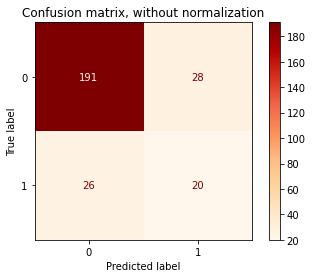

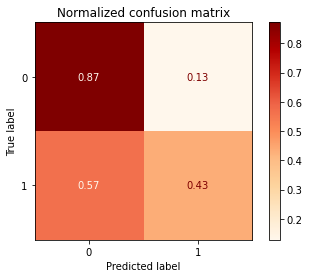


Classification report
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       219
           1       0.42      0.43      0.43        46

    accuracy                           0.80       265
   macro avg       0.65      0.65      0.65       265
weighted avg       0.80      0.80      0.80       265


Metrics

Accuracy 0.7962264150943397
F1-score [0.87614679 0.42553191]
Precision [0.88018433 0.41666667]
Recall [0.87214612 0.43478261]
Roc_auc 0.6534643637085567


Roc curve



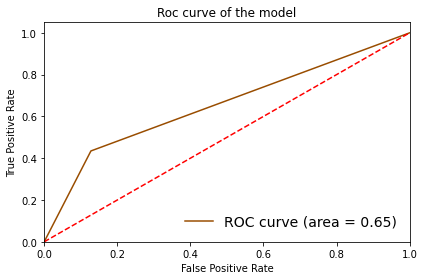


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6715587715422006
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


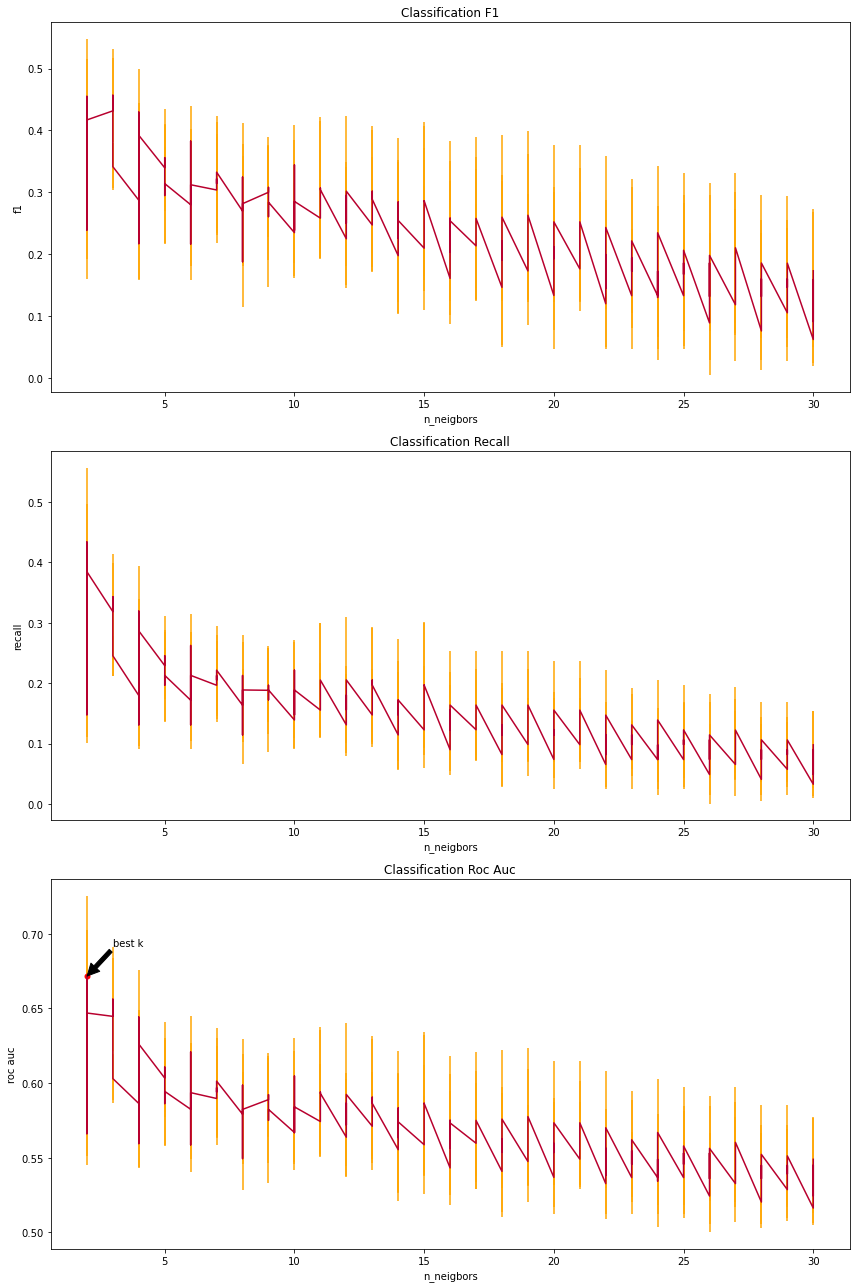



Permutation importances of the training set

OverTime                                           0.016239
JobRole_Laboratory_Technician                      0.011061
JobRole_Sales_Representative                       0.007965
NumCompaniesWorked                                 0.001410
RelationshipSatisfaction                           0.001381
DistanceFromHome                                   0.001362
JobRole_Research_Scientist                         0.001048
JobSatisfaction                                    0.000488
StockOptionLevel                                   0.000166
EnvironmentSatisfaction                            0.000052
TrainingTimesLastYear                              0.000001
OverallSatisfaction                                0.000000
Age                                                0.000000
JobInvolvement                                     0.000000
JobLevel                                           0.000000
JobRole_Manager_Research_&_Development             0.

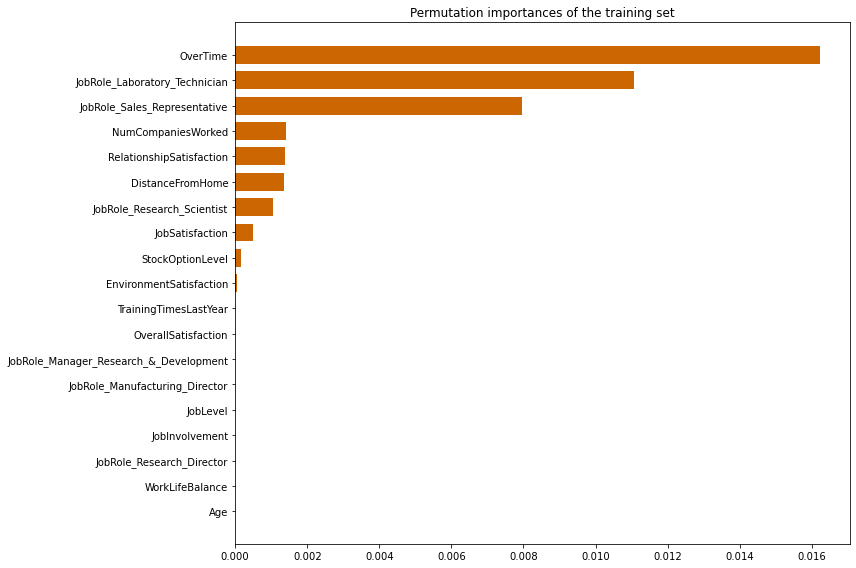



Predictions

Permutation importances of the test set

OverTime                                           0.059335
StockOptionLevel                                   0.055115
JobSatisfaction                                    0.034578
JobRole_Laboratory_Technician                      0.026856
JobRole_Research_Scientist                         0.021465
JobInvolvement                                     0.018913
Age                                                0.012815
JobRole_Sales_Representative                       0.009070
JobRole_Manufacturing_Director                     0.004143
JobRole_Research_Director                          0.003292
OverallSatisfaction                                0.002563
WorkLifeBalance                                    0.000729
JobRole_Manager_Research_&_Development             0.000022
EnvironmentSatisfaction                            -0.001657
NumCompaniesWorked                                 -0.002165
RelationshipSatisfaction                  

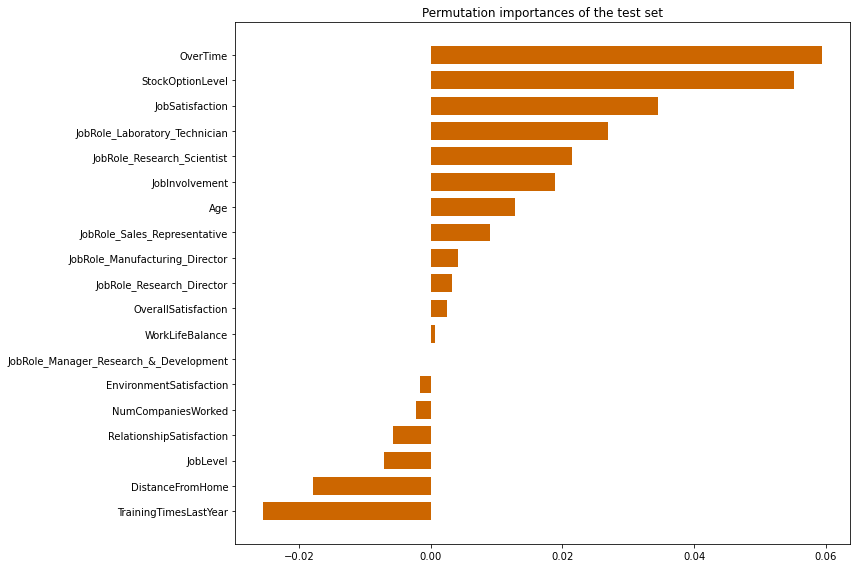



Confusion matrix


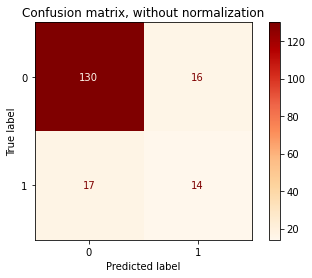

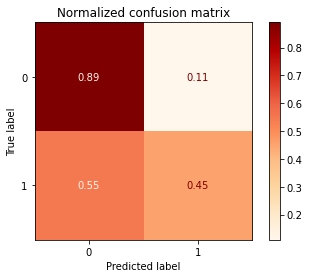


Classification report
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       146
           1       0.47      0.45      0.46        31

    accuracy                           0.81       177
   macro avg       0.68      0.67      0.67       177
weighted avg       0.81      0.81      0.81       177


Metrics

Accuracy 0.8135593220338984
F1-score [0.88737201 0.45901639]
Precision [0.88435374 0.46666667]
Recall [0.89041096 0.4516129 ]
Roc_auc 0.671011931064958


Roc curve



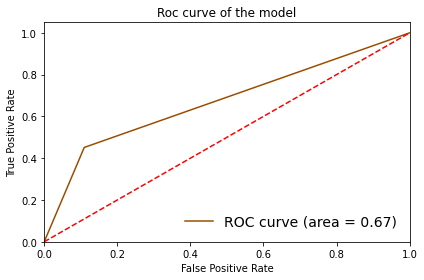


-------------------------------------------------------------------------------------------------------------



In [19]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
max_abs_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = MaxAbsScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, max_abs_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = max_abs_dict

<h4>RobustScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6098447075461435
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


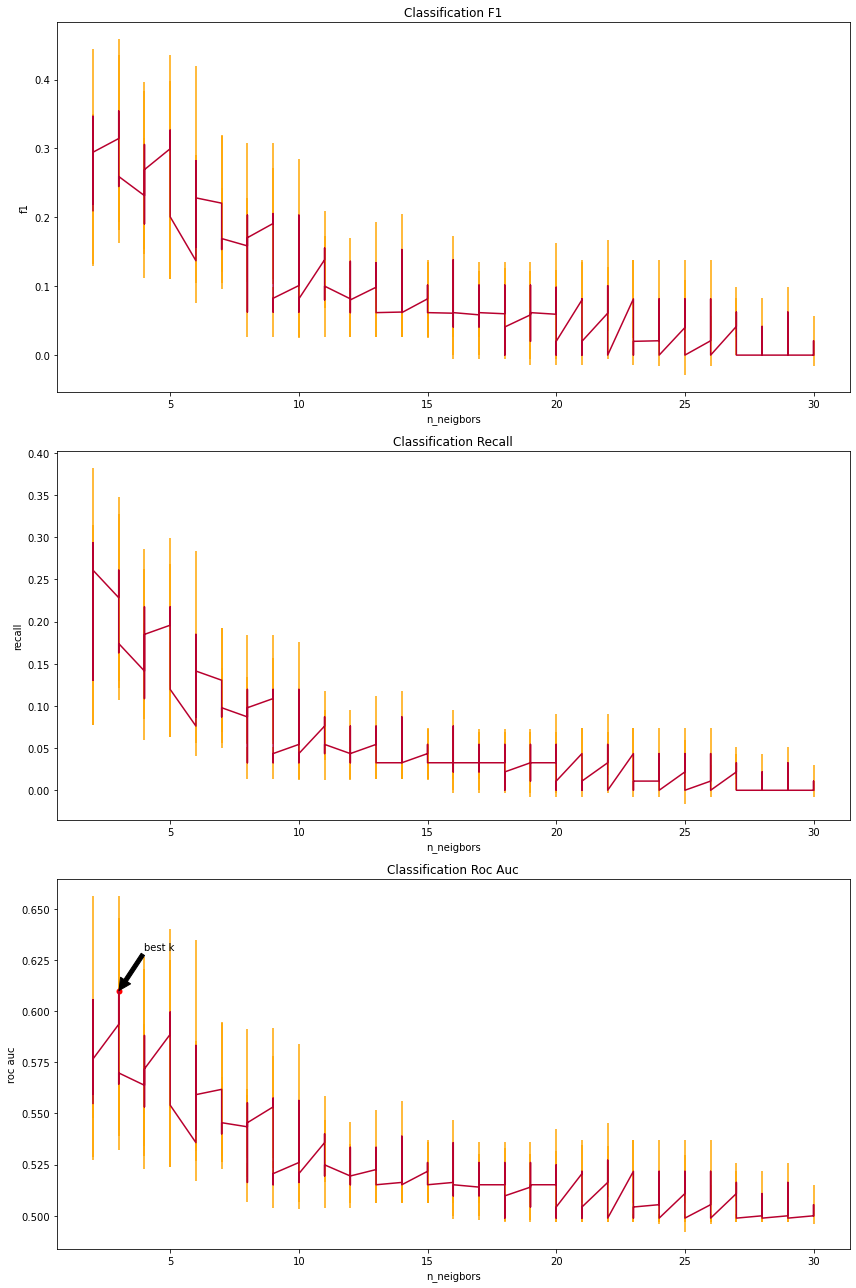



Permutation importances of the training set

StockOptionLevel                                   0.000604
WorkLifeBalance                                    0.000323
TrainingTimesLastYear                              0.000249
Age                                                0.000147
JobInvolvement                                     0.000132
JobLevel                                           0.000129
DistanceFromHome                                   0.000109
NumCompaniesWorked                                 0.000075
RelationshipSatisfaction                           0.000020
JobSatisfaction                                    0.000007
EnvironmentSatisfaction                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.000000
JobRole_Research_Scientist                         0.

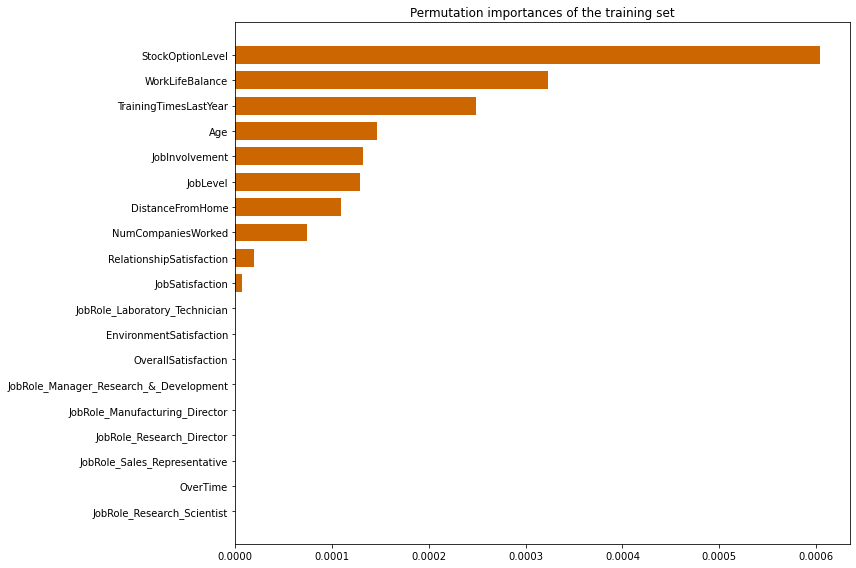



Predictions

Permutation importances of the test set

OverTime                                           0.033316
JobRole_Sales_Representative                       0.017982
JobLevel                                           0.017820
JobSatisfaction                                    0.010591
StockOptionLevel                                   0.007142
JobRole_Research_Director                          0.002216
JobRole_Manufacturing_Director                     0.000876
EnvironmentSatisfaction                            -0.001069
JobRole_Manager_Research_&_Development             -0.001589
WorkLifeBalance                                    -0.002269
JobRole_Research_Scientist                         -0.004308
JobInvolvement                                     -0.011084
JobRole_Laboratory_Technician                      -0.014351
RelationshipSatisfaction                           -0.017938
OverallSatisfaction                                -0.019910
DistanceFromHome                    

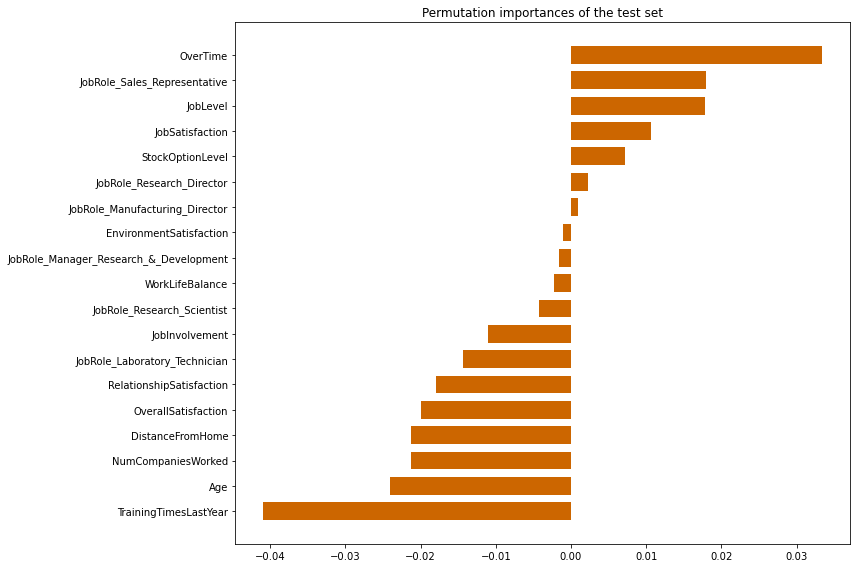



Confusion matrix


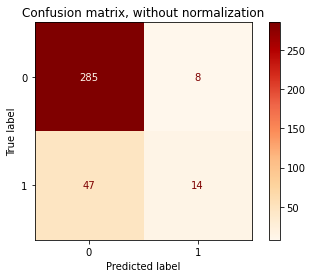

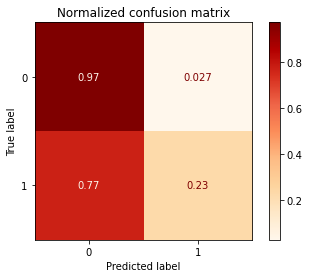


Classification report
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       293
           1       0.64      0.23      0.34        61

    accuracy                           0.84       354
   macro avg       0.75      0.60      0.62       354
weighted avg       0.82      0.84      0.81       354


Metrics

Accuracy 0.844632768361582
F1-score [0.912     0.3373494]
Precision [0.85843373 0.63636364]
Recall [0.97269625 0.2295082 ]
Roc_auc 0.60110222122755


Roc curve



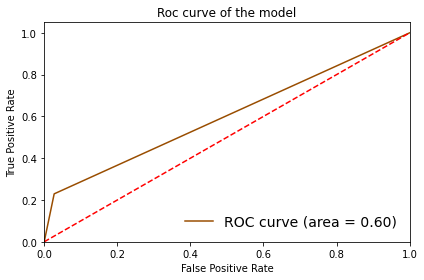


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.609472071324618
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


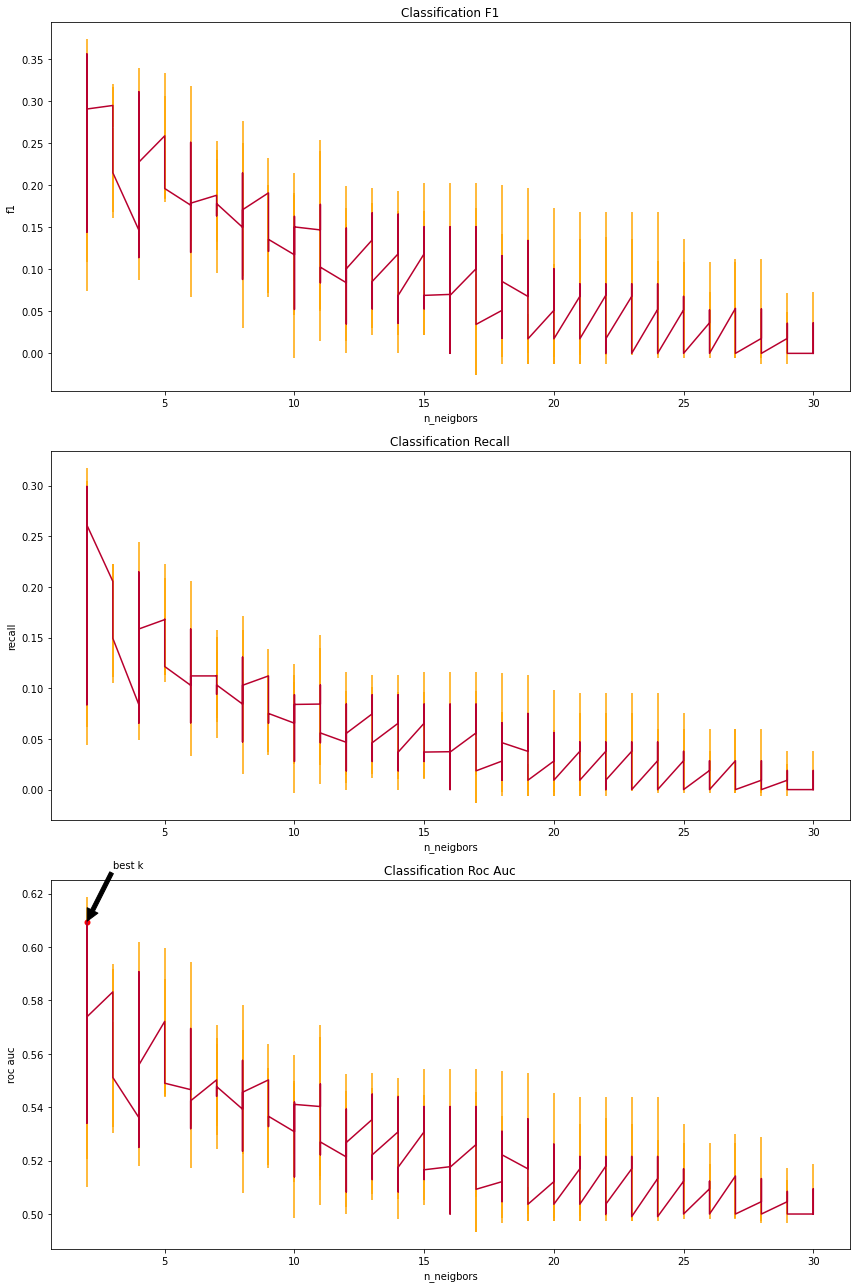



Permutation importances of the training set

StockOptionLevel                                   0.003087
NumCompaniesWorked                                 0.001020
TrainingTimesLastYear                              0.000055
JobInvolvement                                     0.000048
JobLevel                                           0.000002
Age                                                0.000000
DistanceFromHome                                   0.000000
EnvironmentSatisfaction                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.000000
JobRole_Research_Scientist                         0.000000
JobRole_Sales_Representative                       0.000000
JobSatisfaction                                    0.000000
OverTime                                           0.

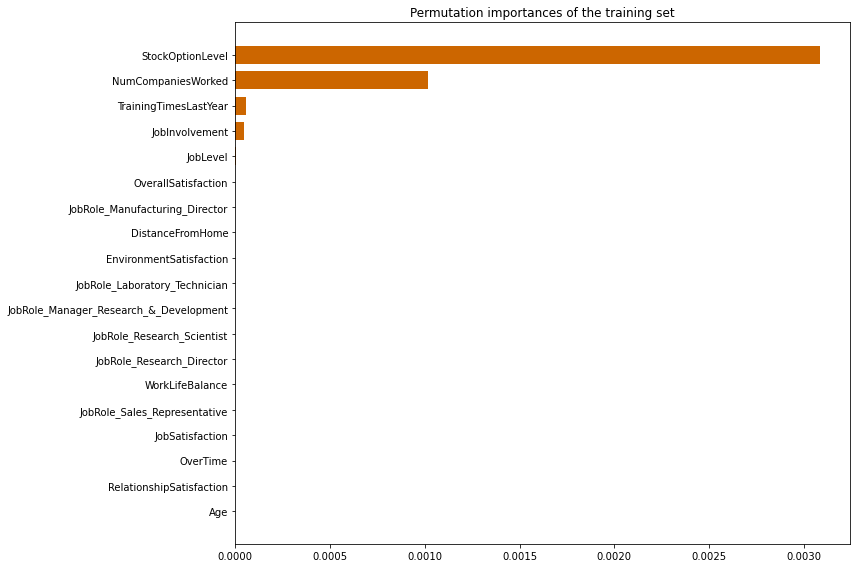



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.053186
OverTime                                           0.037929
JobInvolvement                                     0.037354
NumCompaniesWorked                                 0.034247
JobLevel                                           0.033472
WorkLifeBalance                                    0.028157
RelationshipSatisfaction                           0.023248
JobSatisfaction                                    0.017218
OverallSatisfaction                                0.009073
DistanceFromHome                                   0.006547
JobRole_Manufacturing_Director                     0.006050
JobRole_Research_Director                          0.003067
Age                                                0.002015
JobRole_Research_Scientist                         0.001980
JobRole_Sales_Representative                       0.000844
JobRole_Manager_Research_&_Development      

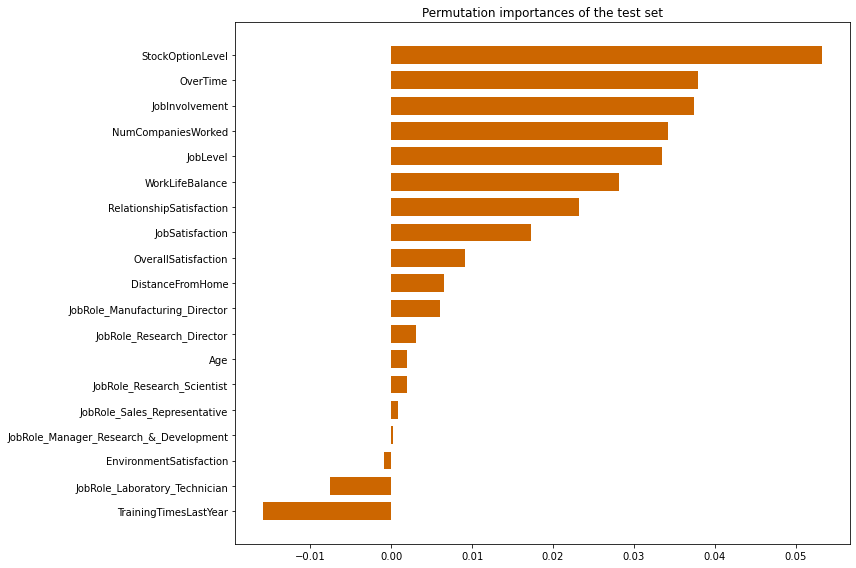



Confusion matrix


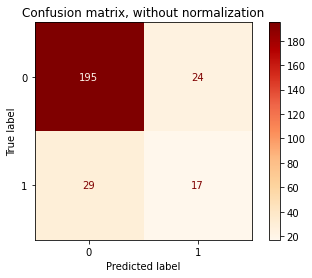

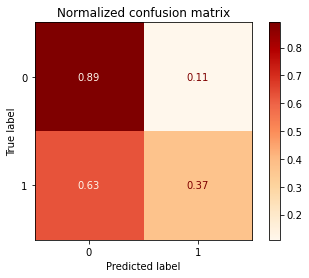


Classification report
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       219
           1       0.41      0.37      0.39        46

    accuracy                           0.80       265
   macro avg       0.64      0.63      0.64       265
weighted avg       0.79      0.80      0.80       265


Metrics

Accuracy 0.8
F1-score [0.88036117 0.3908046 ]
Precision [0.87053571 0.41463415]
Recall [0.89041096 0.36956522]
Roc_auc 0.6299880881477069


Roc curve



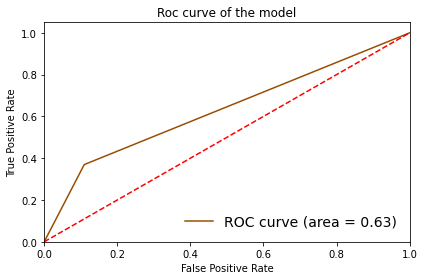


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6363087347179259
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


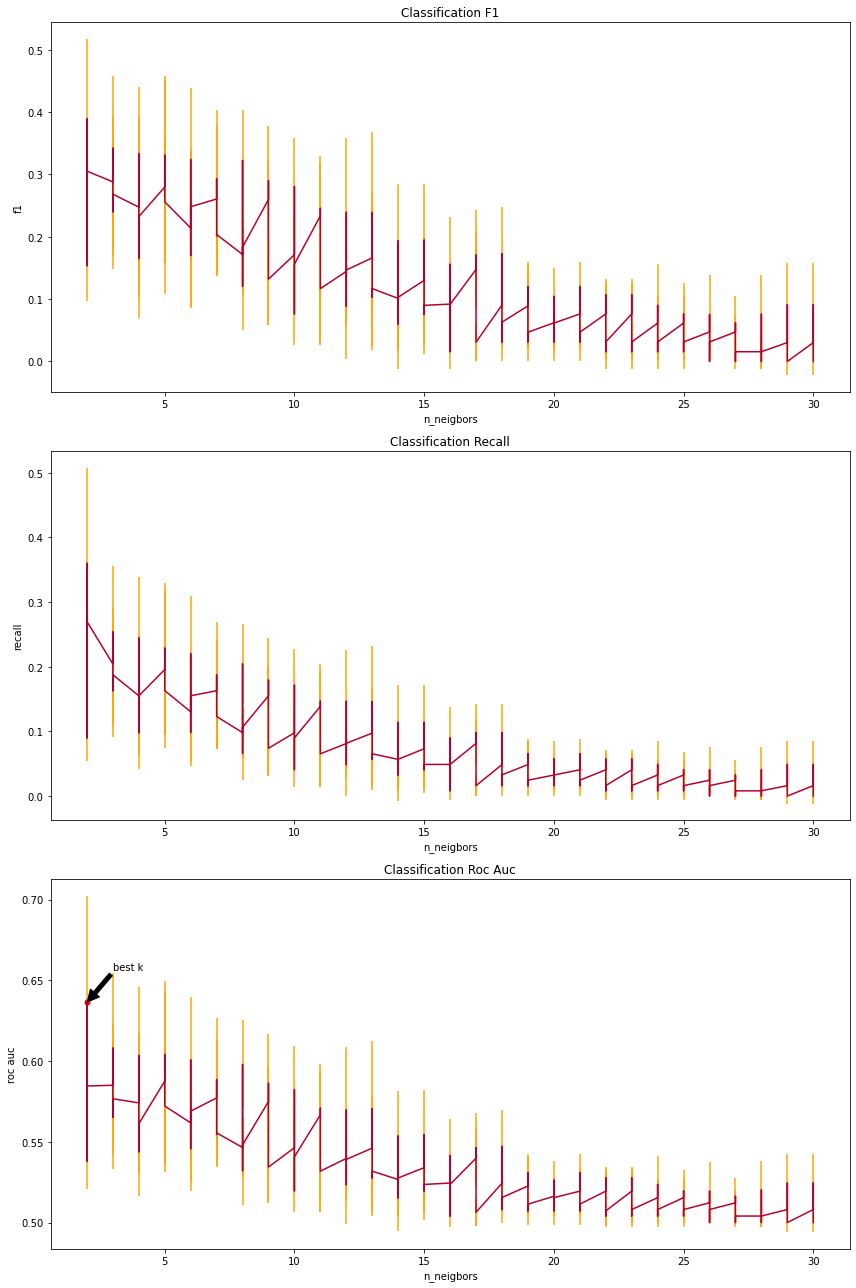



Permutation importances of the training set

StockOptionLevel                                   0.002347
NumCompaniesWorked                                 0.000915
TrainingTimesLastYear                              0.000232
JobInvolvement                                     0.000060
JobLevel                                           0.000001
WorkLifeBalance                                    0.000001
JobSatisfaction                                    0.000000
Age                                                0.000000
DistanceFromHome                                   0.000000
EnvironmentSatisfaction                            0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Director                          0.000000
JobRole_Research_Scientist                         0.000000
JobRole_Sales_Representative                       0.

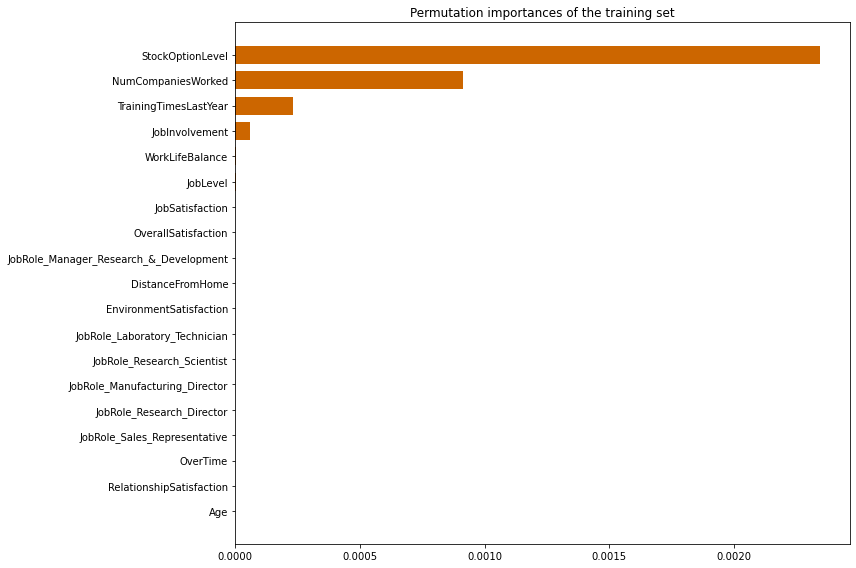



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.079165
JobInvolvement                                     0.066858
JobLevel                                           0.055722
NumCompaniesWorked                                 0.052397
RelationshipSatisfaction                           0.049039
OverTime                                           0.037881
JobSatisfaction                                    0.037771
JobRole_Laboratory_Technician                      0.031739
WorkLifeBalance                                    0.030833
EnvironmentSatisfaction                            0.022492
Age                                                0.021487
TrainingTimesLastYear                              0.019996
OverallSatisfaction                                0.017775
JobRole_Manufacturing_Director                     0.011511
JobRole_Sales_Representative                       0.006507
DistanceFromHome                            

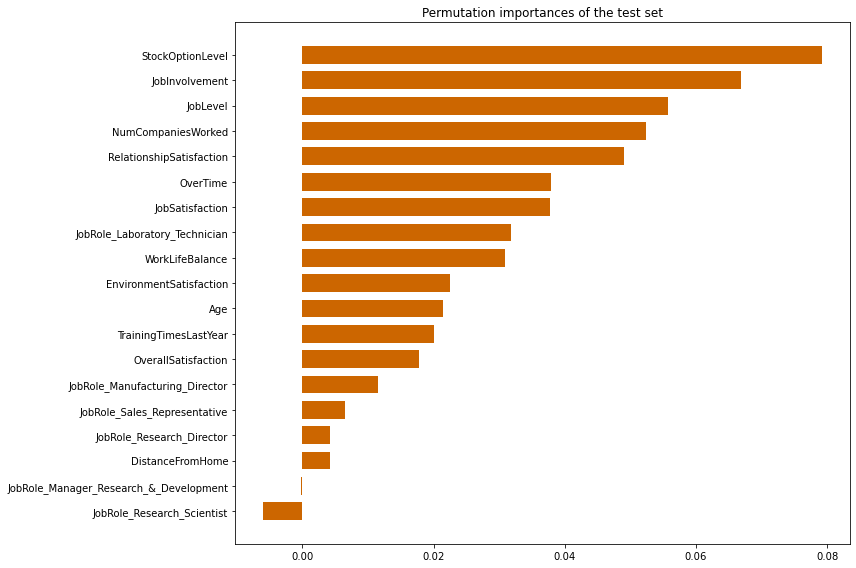



Confusion matrix


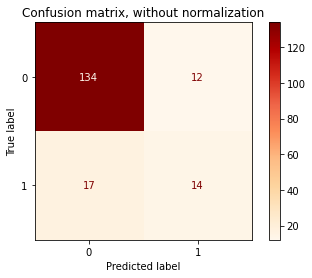

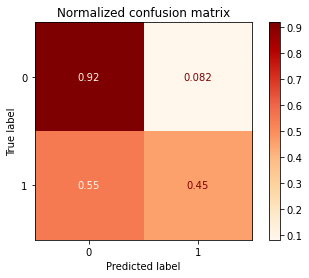


Classification report
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       146
           1       0.54      0.45      0.49        31

    accuracy                           0.84       177
   macro avg       0.71      0.68      0.70       177
weighted avg       0.83      0.84      0.83       177


Metrics

Accuracy 0.8361581920903954
F1-score [0.9023569  0.49122807]
Precision [0.88741722 0.53846154]
Recall [0.91780822 0.4516129 ]
Roc_auc 0.6847105612019444


Roc curve



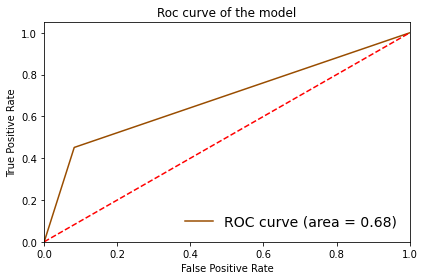


-------------------------------------------------------------------------------------------------------------



In [20]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
robust_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = RobustScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, robust_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = robust_dict

<h4>StandardScaler</h4>

Split:  train: 0.60  -  test: 0.40

Results of the grid search

Best score ('roc_auc'): 0.6404381368531747
Best parameters: {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=3, p=1, weights='distance')

Best k ('n_neighbors'): 3

Plots of the metrics used by the grid search


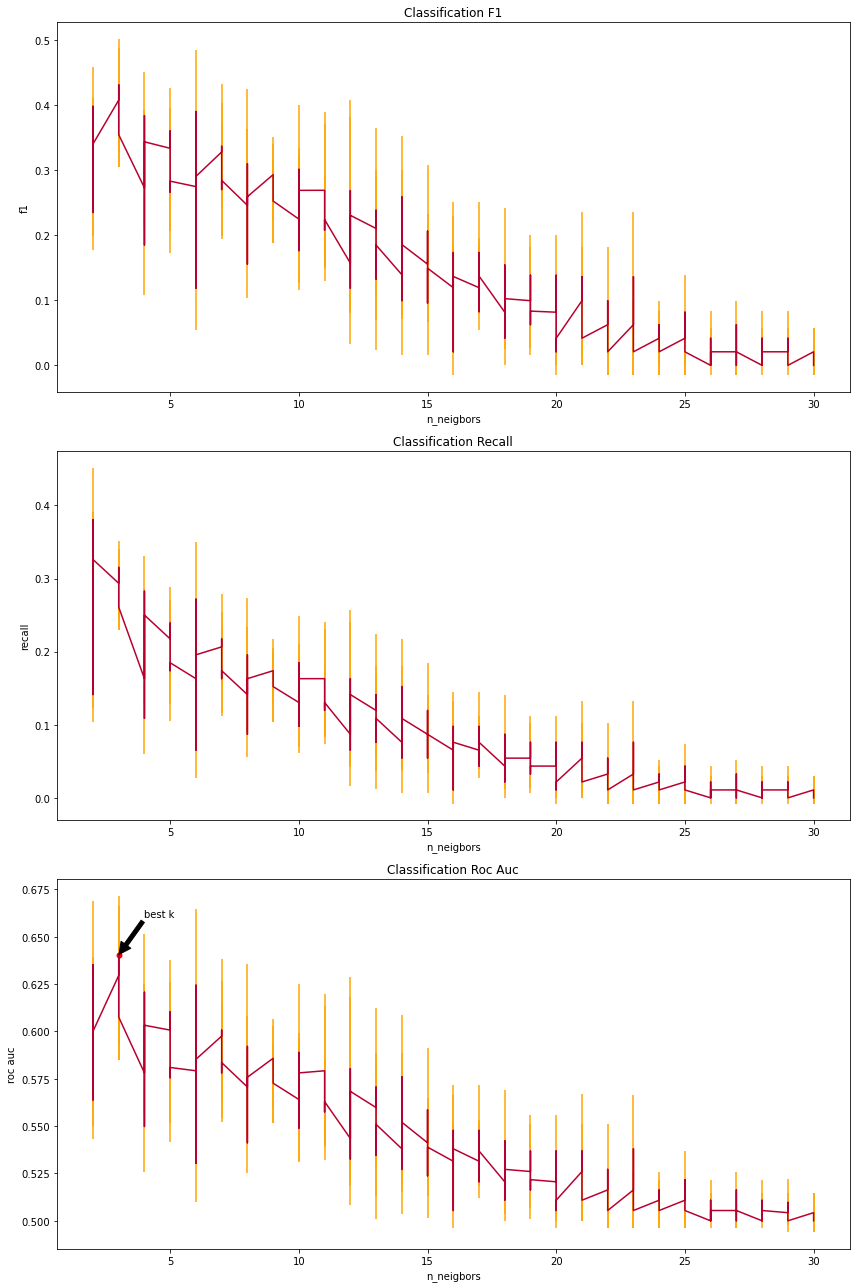



Permutation importances of the training set

JobRole_Sales_Representative                       0.000741
StockOptionLevel                                   0.000209
OverTime                                           0.000154
RelationshipSatisfaction                           0.000097
JobInvolvement                                     0.000082
DistanceFromHome                                   0.000077
JobSatisfaction                                    0.000072
WorkLifeBalance                                    0.000065
JobRole_Manufacturing_Director                     0.000062
JobRole_Laboratory_Technician                      0.000040
Age                                                0.000030
TrainingTimesLastYear                              0.000020
NumCompaniesWorked                                 0.000020
EnvironmentSatisfaction                            0.000010
JobRole_Manager_Research_&_Development             0.000007
JobRole_Research_Director                          0.

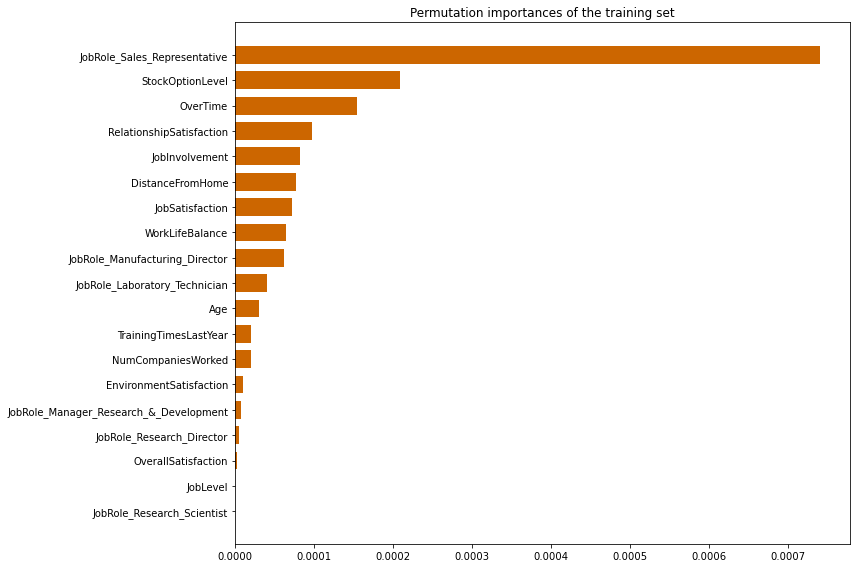



Predictions

Permutation importances of the test set

OverTime                                           0.055620
EnvironmentSatisfaction                            0.035951
NumCompaniesWorked                                 0.035853
JobSatisfaction                                    0.033551
JobRole_Research_Scientist                         0.029875
Age                                                0.027584
WorkLifeBalance                                    0.023709
JobRole_Sales_Representative                       0.022808
RelationshipSatisfaction                           0.021177
JobInvolvement                                     0.015135
StockOptionLevel                                   0.014441
JobRole_Laboratory_Technician                      0.013864
OverallSatisfaction                                0.010896
JobRole_Manufacturing_Director                     0.005494
JobRole_Research_Director                          0.003475
TrainingTimesLastYear                       

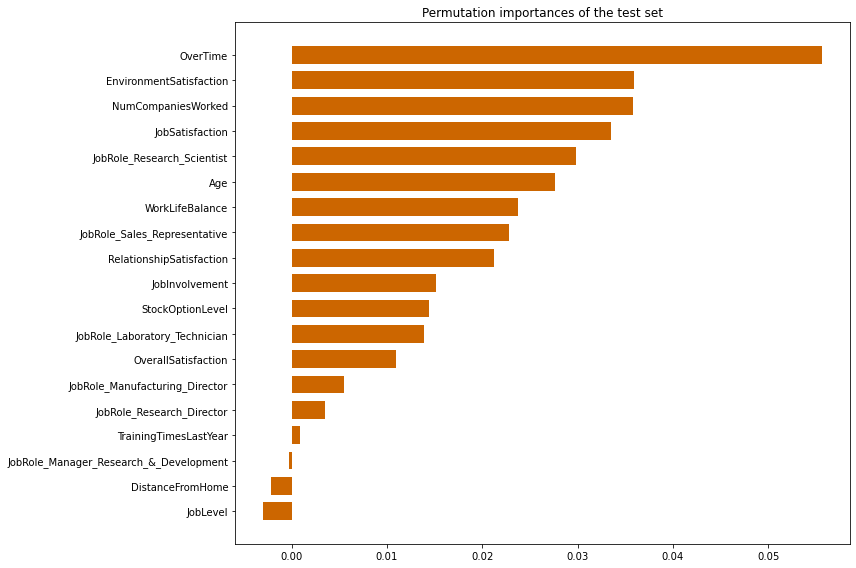



Confusion matrix


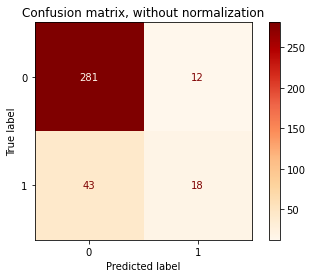

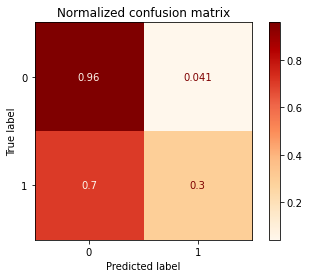


Classification report
              precision    recall  f1-score   support

           0       0.87      0.96      0.91       293
           1       0.60      0.30      0.40        61

    accuracy                           0.84       354
   macro avg       0.73      0.63      0.65       354
weighted avg       0.82      0.84      0.82       354


Metrics

Accuracy 0.844632768361582
F1-score [0.910859  0.3956044]
Precision [0.86728395 0.6       ]
Recall [0.95904437 0.29508197]
Roc_auc 0.6270631679068986


Roc curve



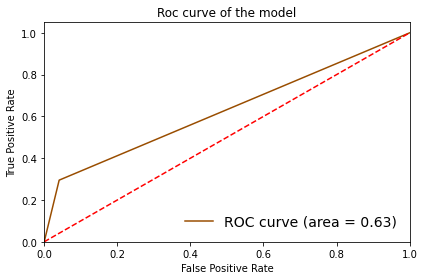


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.70  -  test: 0.30

Results of the grid search

Best score ('roc_auc'): 0.6281845353265136
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


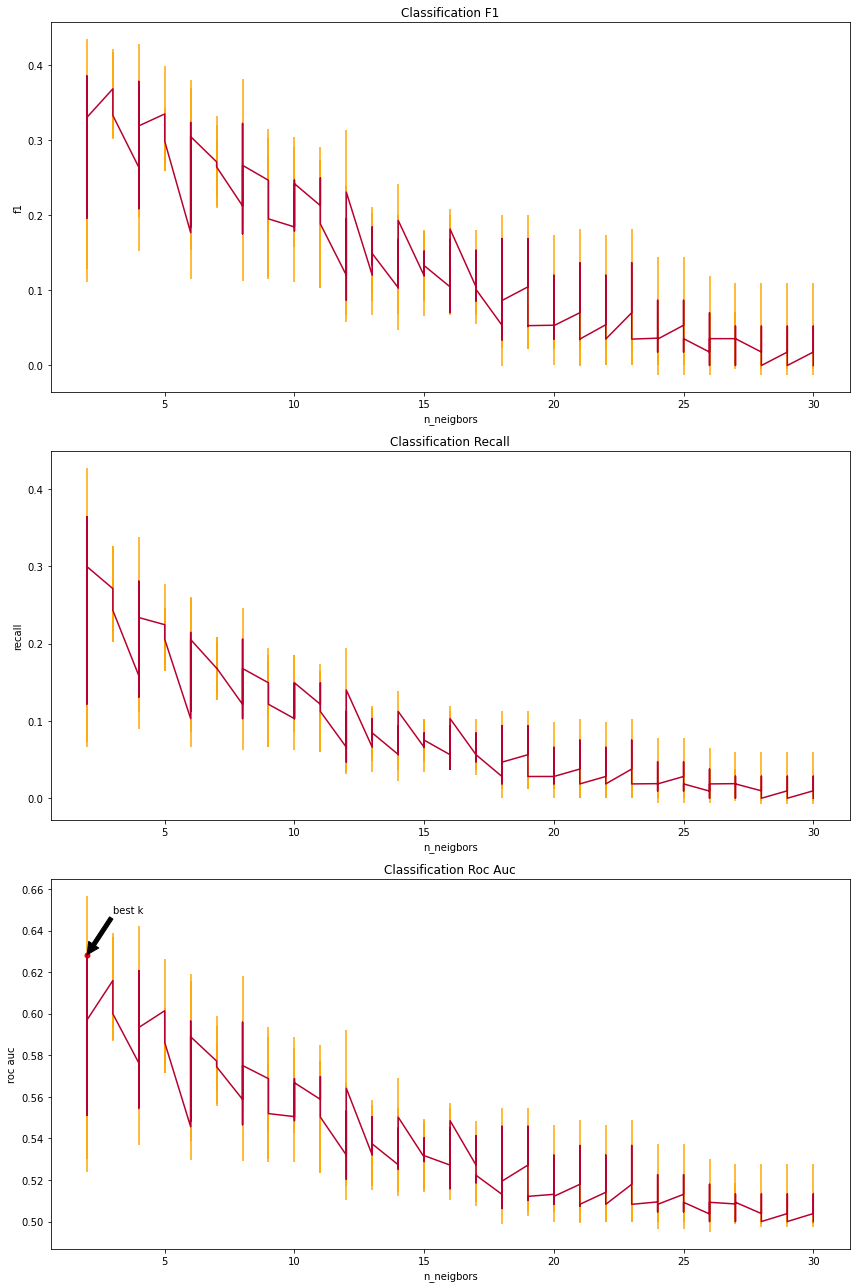



Permutation importances of the training set

JobRole_Sales_Representative                       0.004290
StockOptionLevel                                   0.000024
JobInvolvement                                     0.000013
NumCompaniesWorked                                 0.000004
JobSatisfaction                                    0.000004
JobRole_Research_Director                          0.000002
WorkLifeBalance                                    0.000002
Age                                                0.000000
DistanceFromHome                                   0.000000
EnvironmentSatisfaction                            0.000000
JobLevel                                           0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.000000
JobRole_Research_Scientist                         0.000000
OverTime                                           0.

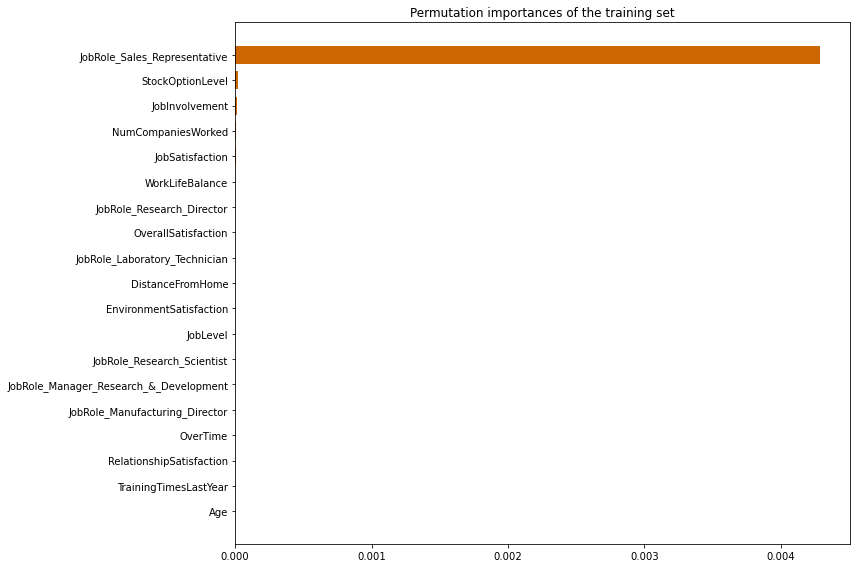



Predictions

Permutation importances of the test set

OverTime                                           0.048992
StockOptionLevel                                   0.045905
Age                                                0.033840
JobInvolvement                                     0.033428
OverallSatisfaction                                0.026608
JobSatisfaction                                    0.024236
NumCompaniesWorked                                 0.022727
JobRole_Sales_Representative                       0.022394
EnvironmentSatisfaction                            0.017128
RelationshipSatisfaction                           0.013168
JobRole_Research_Scientist                         0.011485
JobRole_Manufacturing_Director                     0.008581
JobRole_Research_Director                          0.008373
WorkLifeBalance                                    0.006174
JobLevel                                           0.004576
JobRole_Manager_Research_&_Development      

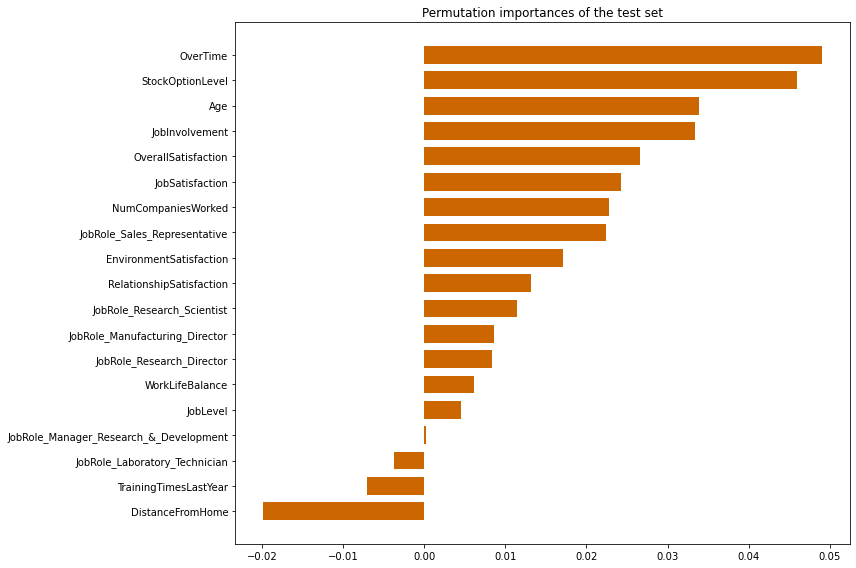



Confusion matrix


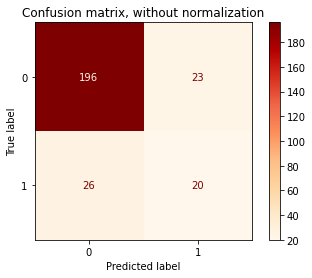

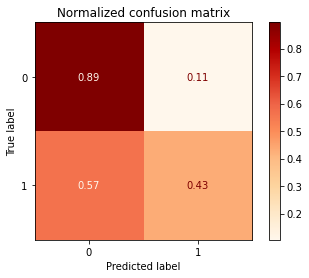


Classification report
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       219
           1       0.47      0.43      0.45        46

    accuracy                           0.82       265
   macro avg       0.67      0.66      0.67       265
weighted avg       0.81      0.82      0.81       265


Metrics

Accuracy 0.8150943396226416
F1-score [0.88888889 0.4494382 ]
Precision [0.88288288 0.46511628]
Recall [0.89497717 0.43478261]
Roc_auc 0.6648798888227119


Roc curve



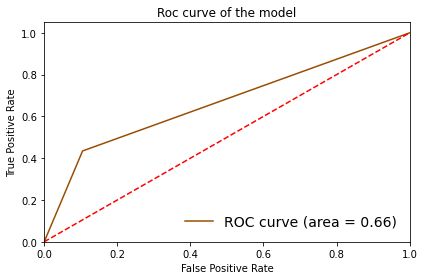


-------------------------------------------------------------------------------------------------------------

Split:  train: 0.80  -  test: 0.20

Results of the grid search

Best score ('roc_auc'): 0.6695076594491088
Best parameters: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Best estimator: KNeighborsClassifier(n_neighbors=2, p=1, weights='distance')

Best k ('n_neighbors'): 2

Plots of the metrics used by the grid search


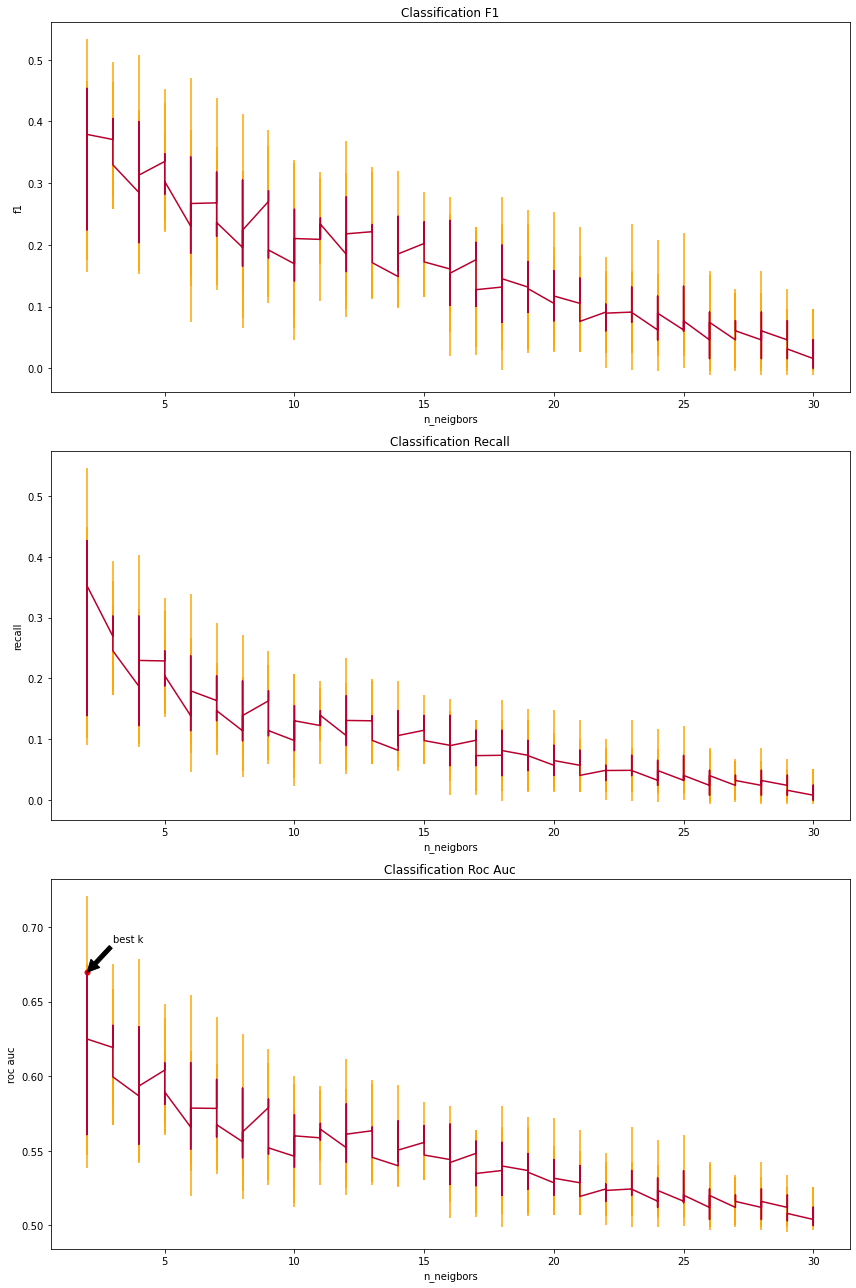



Permutation importances of the training set

JobRole_Sales_Representative                       0.003382
JobInvolvement                                     0.000022
StockOptionLevel                                   0.000022
OverTime                                           0.000015
TrainingTimesLastYear                              0.000013
NumCompaniesWorked                                 0.000006
JobSatisfaction                                    0.000004
WorkLifeBalance                                    0.000001
JobRole_Research_Director                          0.000001
Age                                                0.000000
DistanceFromHome                                   0.000000
EnvironmentSatisfaction                            0.000000
JobLevel                                           0.000000
JobRole_Laboratory_Technician                      0.000000
JobRole_Manager_Research_&_Development             0.000000
JobRole_Manufacturing_Director                     0.

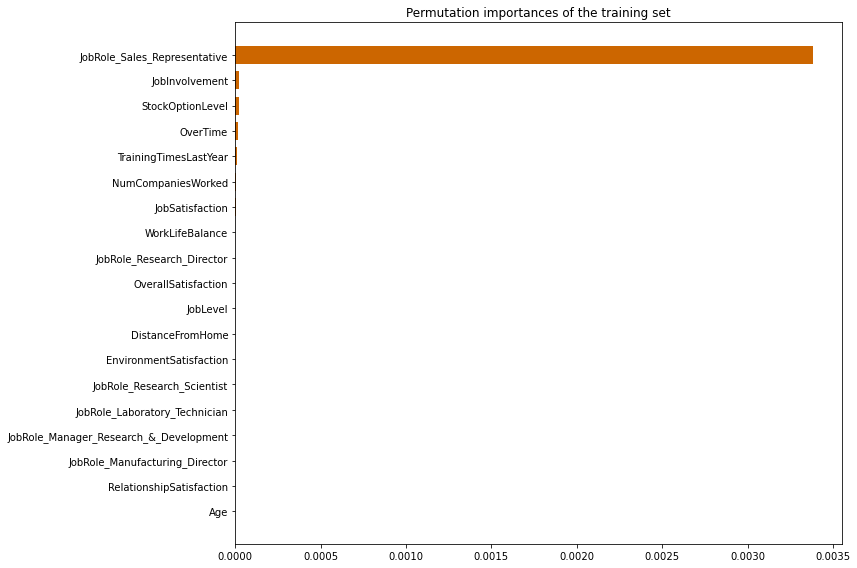



Predictions

Permutation importances of the test set

StockOptionLevel                                   0.074017
OverTime                                           0.058396
NumCompaniesWorked                                 0.056949
JobInvolvement                                     0.053635
Age                                                0.047536
JobSatisfaction                                    0.046443
JobRole_Sales_Representative                       0.031374
JobRole_Laboratory_Technician                      0.030148
JobLevel                                           0.029607
RelationshipSatisfaction                           0.029021
WorkLifeBalance                                    0.026425
EnvironmentSatisfaction                            0.025508
OverallSatisfaction                                0.024216
JobRole_Research_Scientist                         0.016140
JobRole_Research_Director                          0.015488
TrainingTimesLastYear                       

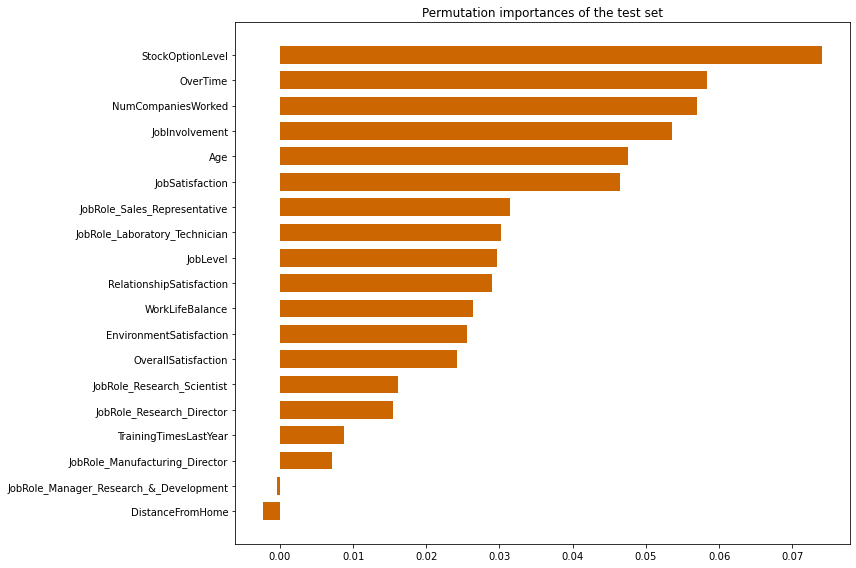



Confusion matrix


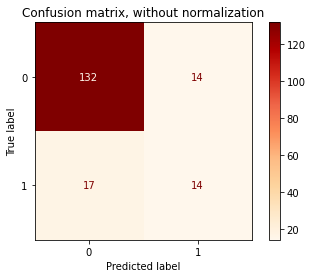

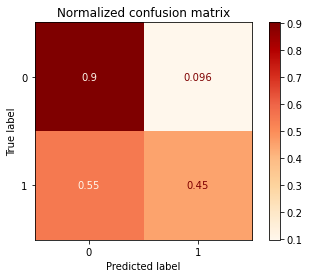


Classification report
              precision    recall  f1-score   support

           0       0.89      0.90      0.89       146
           1       0.50      0.45      0.47        31

    accuracy                           0.82       177
   macro avg       0.69      0.68      0.68       177
weighted avg       0.82      0.82      0.82       177


Metrics

Accuracy 0.8248587570621468
F1-score [0.89491525 0.47457627]
Precision [0.88590604 0.5       ]
Recall [0.90410959 0.4516129 ]
Roc_auc 0.6778612461334513


Roc curve



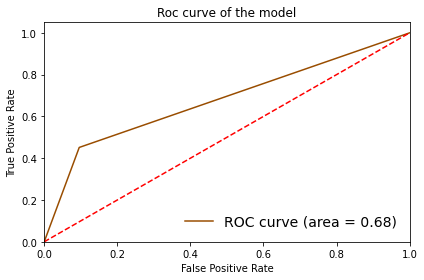


-------------------------------------------------------------------------------------------------------------



In [21]:
possible_splits = ((0.6, 0.4), (0.7, 0.3), (0.8, 0.2))
k_range = list(range(2, 30 + 1))
metric_list = {'f1': make_scorer(f1_score),
               'recall': make_scorer(recall_score),
               'roc_auc': make_scorer(roc_auc_score)}
standard_dict = {}

for a, b in possible_splits:
    
    print("Split:  train: %0.2f  -  test: %0.2f" % (a, b))
    print()
    
    #normalization
    scaler = StandardScaler()
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = a, test_size = b, random_state=100, stratify=y)
    
    scaler.fit(X_train)
    X_train_normalized = scaler.transform(X_train)
    X_test_normalized = scaler.transform(X_test)
    
    #classifier
    clf = KNeighborsClassifier()
    
    #parameter list for the grid search
    param_list = {'n_neighbors': k_range,
                  'weights': ['uniform', 'distance'],
                  'p': [1, 2]}
    
    #grid search
    grid_search = GridSearchCV(clf, param_grid = param_list, scoring = metric_list, cv = 4, refit = 'roc_auc')
    grid_search.fit(X_train_normalized, y_train)
    
    #results of the grid search
    print('\033[1m'"Results of the grid search"'\033[0m')
    print()
    print("Best score ('roc_auc'): %s" % grid_search.best_score_)
    print("Best parameters: %s" % grid_search.best_params_)
    print("Best estimator: %s" % grid_search.best_estimator_)
    print()
    print("Best k ('n_neighbors'): %s" % grid_search.best_params_['n_neighbors'])
    print()
    
    #plot grid search results
    print('\033[1m'"Plots of the metrics used by the grid search"'\033[0m')
    plot_grid_search_results(grid_search.cv_results_, grid_search.best_params_, grid_search.best_score_)
    
    print()
    print()
    
    clf = grid_search.best_estimator_ #select the best estimator
    
    
    #perform permutation importance of the training set
    
    results1 = permutation_importance(clf, X_train_normalized, y_train, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the training set
    title1 = "Permutation importances of the training set"
    print('\033[1m'+title1+'\033[0m')
    print()
    
    train_sorted_feature_importances = results_permutation_importance(results1, attributes)
    for t in train_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results1, attributes, title1)
    
    print()
    print()
    

    #Predictions
    
    print('\033[1m'"Predictions"'\033[0m')
    print()
    
    y_pred = clf.predict(X_test_normalized)  #predict
    
    
    # perform permutation importance of the test set
    
    results2 = permutation_importance(clf, X_test_normalized, y_test, scoring='roc_auc', n_repeats = 10)
    
    #print results of permutation importance of the train
    title2 = "Permutation importances of the test set"
    print('\033[1m'+title2+'\033[0m')
    print()
    
    test_sorted_feature_importances = results_permutation_importance(results2, attributes)
    for t in test_sorted_feature_importances:
        print('{0:50} {1:.6f}'.format(t[0], t[1]))
        
    print()
    plot_permutation_importance(results2, attributes, title2)
    
    print()
    print()
    
    
    #confusion matrix
    print('\033[1m'"Confusion matrix"'\033[0m')
    
    #plot_confusion_matrix(clf, X_test_normalized, y_test, cmap = 'OrRd')
    draw_confusion_matrix(clf, X_test_normalized, y_test)
        
    print()
        
    print('\033[1m'"Classification report"'\033[0m')
    print(classification_report(y_test, y_pred))
        
    print()
        
    print('\033[1m'"Metrics"'\033[0m')
    print()
        
    print('Accuracy %s' % accuracy_score(y_test, y_pred))
          
    print('F1-score %s' % f1_score(y_test, y_pred, labels = [0, 1], average=None, zero_division = 1))
        
    print('Precision %s' % precision_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
    
    print('Recall %s' % recall_score(y_test, y_pred, labels = [0, 1], average = None, zero_division = 1))
      
    print('Roc_auc %s' % roc_auc_score(y_test, y_pred, average = None))
    
    print()
    print()
    
    #plot the Roc Curve of the model
    print('\033[1m'"Roc curve"'\033[0m')
    print()
    key = "%s-%s" % (int(a*100), int(b*100))
    draw_roc_curve(y_test, y_pred, standard_dict, key)
    
    print()
    print('-------------------------------------------------------------------------------------------------------------')
    print()

s = str(scaler).replace("()", "")
scaler_dict[s] = standard_dict

In [22]:
scaler_dict

{'MinMaxScaler': {'60-40': {'fpr': [0.0, 0.04436860068259386, 1.0],
   'tpr': [0.0, 0.26229508196721313, 1.0],
   'roc': 0.6089632406423097},
  '70-30': {'fpr': [0.0, 0.1232876712328767, 1.0],
   'tpr': [0.0, 0.41304347826086957, 1.0],
   'roc': 0.6448779035139963},
  '80-20': {'fpr': [0.0, 0.10273972602739725, 1.0],
   'tpr': [0.0, 0.41935483870967744, 1.0],
   'roc': 0.6583075563411402}},
 'MaxAbsScaler': {'60-40': {'fpr': [0.0, 0.11604095563139932, 1.0],
   'tpr': [0.0, 0.36065573770491804, 1.0],
   'roc': 0.6223073910367595},
  '70-30': {'fpr': [0.0, 0.1278538812785388, 1.0],
   'tpr': [0.0, 0.43478260869565216, 1.0],
   'roc': 0.6534643637085567},
  '80-20': {'fpr': [0.0, 0.1095890410958904, 1.0],
   'tpr': [0.0, 0.45161290322580644, 1.0],
   'roc': 0.671011931064958}},
 'RobustScaler': {'60-40': {'fpr': [0.0, 0.027303754266211604, 1.0],
   'tpr': [0.0, 0.22950819672131148, 1.0],
   'roc': 0.60110222122755},
  '70-30': {'fpr': [0.0, 0.1095890410958904, 1.0],
   'tpr': [0.0, 0.3695

In [27]:
temporal_info = {}

In [28]:
model_name = '20f onehot-encoded no discretized'

In [29]:
temporal_info[model_name] = scaler_dict['RobustScaler']['80-20']
temporal_info

{'20f onehot-encoded no discretized': {'fpr': [0.0, 0.0821917808219178, 1.0],
  'tpr': [0.0, 0.45161290322580644, 1.0],
  'roc': 0.6847105612019444}}

In [30]:
with open('temporal_info.json', "r+") as json_file: 
    data = json.load(json_file)
    data['no_discr']['validation'].update(temporal_info)

    
with open('temporal_info.json','w') as f: 
    json.dump(data, f, indent=4)